In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

Price  neg_oil  neu_oil  pos_oil  compound_oil  neg_war  \
Date                                                                      
2023-04-03  84.930000    0.000    0.000    0.000        0.0000    0.000   
2023-04-04  84.940002    0.000    0.000    0.000        0.0000    0.000   
2023-04-05  84.989998    0.000    0.000    0.000        0.0000    0.000   
2023-04-06  85.120003    0.000    0.000    0.000        0.0000    0.000   
2023-04-10  84.180000    0.086    0.816    0.098        0.9796    0.144   

            neu_war  pos_war  compound_war  
Date                                        
2023-04-03    0.000    0.000        0.0000  
2023-04-04    0.000    0.000        0.0000  
2023-04-05    0.000    0.000        0.0000  
2023-04-06    0.776    0.224        0.9866  
2023-04-10    0.708    0.147       -0.1356

In [5]:
data.describe().transpose()

count       mean       std        min        25%        50%  \
Price         271.0  82.667343  5.567707  71.839996  78.139999  82.739998   
neg_oil       271.0   0.023033  0.024112   0.000000   0.000000   0.017500   
neu_oil       271.0   0.496814  0.361231   0.000000   0.000000   0.604750   
pos_oil       271.0   0.064340  0.055087   0.000000   0.000000   0.062000   
compound_oil  271.0   0.378112  0.429797  -0.955900   0.000000   0.270900   
neg_war       271.0   0.082097  0.071262   0.000000   0.013000   0.073000   
neu_war       271.0   0.802173  0.128576   0.000000   0.773586   0.817200   
pos_war       271.0   0.104691  0.065619   0.000000   0.066000   0.118000   
compound_war  271.0   0.163507  0.595739  -0.999900  -0.357750   0.115525   

                    75%        max  
Price         86.355000  96.550003  
neg_oil        0.038271   0.116000  
neu_oil        0.831000   0.960000  
pos_oil        0.100667   0.181000  
compound_oil   0.950900   0.999900  
neg_war        0.132375   0.272500  
neu_war        0.854250   1.000000  
pos_war        0.139875   0.435000  
compound_war   0.701659   0.986600

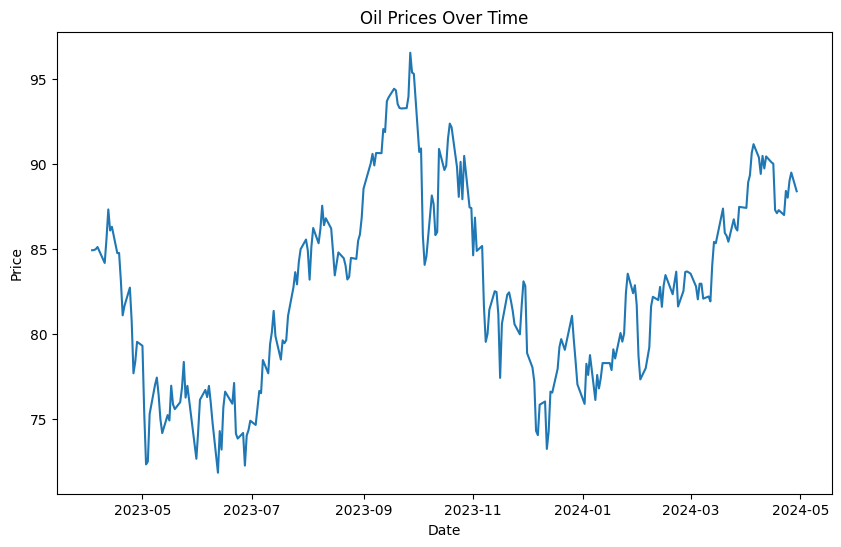

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
oil_data = data[['Price']]
oil_data.head()

Price
Date                 
2023-04-03  84.930000
2023-04-04  84.940002
2023-04-05  84.989998
2023-04-06  85.120003
2023-04-10  84.180000

In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_4084\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [11]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [11]:
test_df

Price
Date                
2024-03-12  0.407932
2024-03-13  0.493323
2024-03-14  0.549575
2024-03-15  0.546337
2024-03-18  0.609065
2024-03-19  0.628895
2024-03-20  0.571024
2024-03-21  0.564144
2024-03-22  0.549980
2024-03-25  0.603399
2024-03-26  0.583165
2024-03-27  0.576689
2024-03-28  0.632942
2024-04-01  0.630514
2024-04-02  0.691218
2024-04-03  0.708620
2024-04-04  0.761230
2024-04-05  0.782274
2024-04-08  0.750303
2024-04-09  0.711453
2024-04-10  0.754351
2024-04-11  0.724403
2024-04-12  0.753136
2024-04-15  0.738972
2024-04-16  0.735734
2024-04-17  0.625253
2024-04-18  0.617968
2024-04-19  0.625253
2024-04-22  0.613517
2024-04-23  0.670983
2024-04-24  0.654795
2024-04-25  0.694860
2024-04-26  0.714690
2024-04-29  0.670174

In [12]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [13]:
train_df.columns

Index(['Price'], dtype='object')

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [19]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [20]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [21]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [22]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [23]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [24]:
train_df.shape

(189, 1)

In [25]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [26]:
input_shape

(30, 1)

In [27]:
# linear = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=input_shape)
# ])

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model
# linear=get_ensemble_model2(input_shape)
model=get_lstm_model_1(input_shape)
# model=get_transformer_model(input_shape)

In [28]:
history = compile_and_fit(model, window)

histories_Linear = history
val_performance_Linear = model.evaluate(window.val, return_dict=True)
performance_Linear = model.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
159/159 [==============================] - 9s 26ms/step - loss: 0.0225 - mean_absolute_percentage_error: 809069.5625 - mean_absolute_error: 0.1174 - val_loss: 0.0391 - val_mean_absolute_percentage_error: 43.8498 - val_mean_absolute_error: 0.1957 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 3s 19ms/step - loss: 0.0239 - mean_absolute_percentage_error: 1036915.7500 - mean_absolute_error: 0.1207 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 40.1564 - val_mean_absolute_error: 0.1794 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 3s 19ms/step - loss: 0.0204 - mean_absolute_percentage_error: 1196995.6250 - mean_absolute_error: 0.1130 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 38.1214 - val_mean_absolute_error: 0.1704 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 3s 18ms/step - loss: 0.0204 - mean_absolute_percentage_error: 1283275.1250 - mean_absolute_error: 0.1137 - val_loss: 0.0234 - val_

In [29]:
histories_Linear.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'lr'])

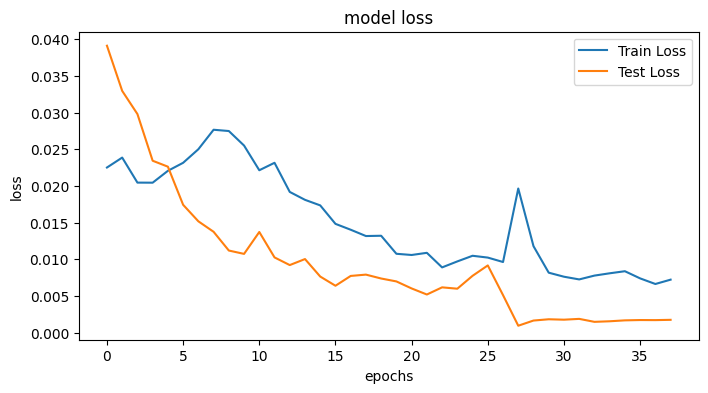

In [30]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [31]:
all_predict = model.predict(window.all_data)
all_predict

241/241 [==============================] - 2s 4ms/step


array([[0.18463862],
       [0.18381073],
       [0.22937278],
       [0.233687  ],
       [0.22535151],
       [0.22776498],
       [0.24808787],
       [0.2922637 ],
       [0.27072865],
       [0.26726574],
       [0.19456036],
       [0.12753652],
       [0.12761739],
       [0.1825762 ],
       [0.2316694 ],
       [0.24615729],
       [0.26333576],
       [0.24964988],
       [0.2135317 ],
       [0.12795806],
       [0.12718529],
       [0.11757785],
       [0.1693041 ],
       [0.22586857],
       [0.23814824],
       [0.26510906],
       [0.21477763],
       [0.17223403],
       [0.15660462],
       [0.11047636],
       [0.12213641],
       [0.1459863 ],
       [0.17370056],
       [0.18311152],
       [0.22994919],
       [0.253185  ],
       [0.30271906],
       [0.30957016],
       [0.34263045],
       [0.371471  ],
       [0.4068287 ],
       [0.39072   ],
       [0.35071328],
       [0.34870523],
       [0.34635502],
       [0.34898967],
       [0.3790087 ],
       [0.427

In [32]:
all_predict.shape

(241, 1)

In [33]:
X_all_data = scaler.inverse_transform(all_predict)
# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

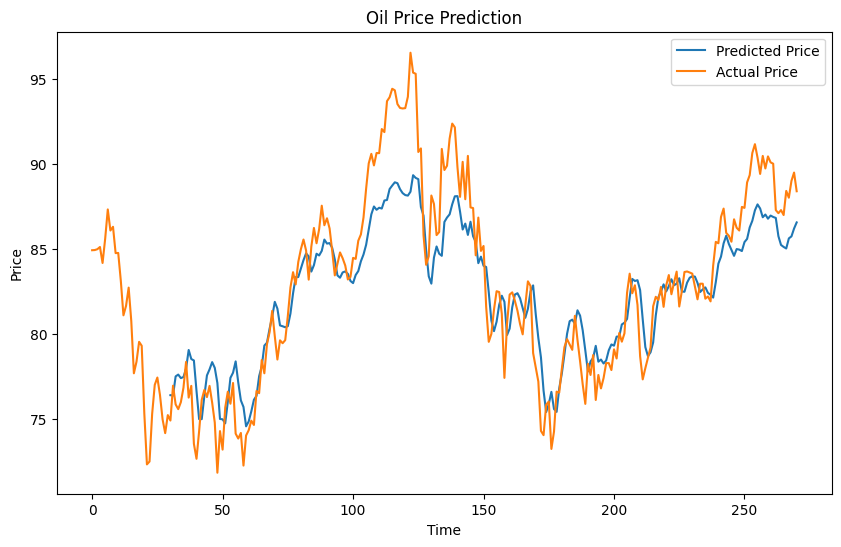

In [34]:
# Plot predictions vs actual values
seq_length = 30

plt.figure(figsize=(10, 6))

plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
# plt.savefig('outputs/lstm model 01 Oil Price Prediction.png')
plt.show()

In [35]:

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

In [36]:

def get_lstm_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [37]:

def get_lstm_model_3(input_shape):
    input = keras.Input(shape=input_shape)

    layer = LSTM(units=60, return_sequences=True)(input)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=50, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=40, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=20, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    output = Dense(units=1)(layer)

    model=keras.Model(input, output)


    return model

In [38]:
def get_lstm_model_4(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [39]:
def get_lstm_model_5(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [40]:

def get_bidirectional_lstm_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [41]:
def get_bidirectional_lstm_model_2(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_3(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_4(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [42]:
def get_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    return model

In [43]:
def get_attention_lstm_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    dense = Dense(1)(attention)
    model = tf.keras.Model(inputs=inputs, outputs=dense)
    return model

In [44]:
models_name_list={
    'lstm_model_1' : get_lstm_model_1 ,
    'lstm_model_2' : get_lstm_model_2 ,
    'lstm_model_3' : get_lstm_model_3 ,
    'lstm_model_4' : get_lstm_model_4 ,
    'lstm_model_4' : get_lstm_model_5 ,
    'bidirectional_lstm_model_1' : get_bidirectional_lstm_model_1 ,
    'bidirectional_lstm_model_2' : get_bidirectional_lstm_model_2 ,
    'bidirectional_lstm_model_3' : get_bidirectional_lstm_model_3 ,
    'bidirectional_lstm_model_4' : get_bidirectional_lstm_model_4 ,
    'stacked_lstm_model' : get_stacked_lstm_model ,
    'attention_lstm_model' : get_attention_lstm_model ,
}
models_list={}

In [45]:
for model_type in models_name_list:
    print(model_type)

lstm_model_1
lstm_model_2
lstm_model_3
lstm_model_4
bidirectional_lstm_model_1
bidirectional_lstm_model_2
bidirectional_lstm_model_3
bidirectional_lstm_model_4
stacked_lstm_model
attention_lstm_model


In [46]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [47]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ lstm_model_1 ------------



-------------- lstm_model_1_weekly (7, 1) --------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable para

In [48]:
models_list

{'lstm_model_1_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x256667a5e90>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'lstm_model_1_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x25667633c90>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'lstm_model_1_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x256676e2ad0>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'lstm_model_2_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x256676c4950>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7

In [49]:
len(models_list)

30

In [50]:
models_list['lstm_model_1_weekly']

{'model': <keras.src.engine.sequential.Sequential at 0x256667a5e90>,
 'window': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'seq_length': 7}

In [51]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [52]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ lstm_model_1_weekly ------------
Epoch 1/100
182/182 [==============================] - 6s 12ms/step - loss: 0.0230 - mean_absolute_percentage_error: 865570.3750 - mean_absolute_error: 0.1144 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 32.9587 - val_mean_absolute_error: 0.1365 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 1s 7ms/step - loss: 0.0218 - mean_absolute_percentage_error: 879842.1875 - mean_absolute_error: 0.1190 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 34.2559 - val_mean_absolute_error: 0.1422 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 1s 7ms/step - loss: 0.0227 - mean_absolute_percentage_error: 976338.8125 - mean_absolute_error: 0.1202 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 34.1432 - val_mean_absolute_error: 0.1419 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 1s 7ms/step - loss: 0.0231 - mean_absolute_percentage_error: 1057203.1250 - mean_abso

## evaluate

In [53]:
histories

{'lstm_model_1_weekly': <keras.src.callbacks.History at 0x2566f30a250>,
 'lstm_model_1_bi-weekly': <keras.src.callbacks.History at 0x2566f32e950>,
 'lstm_model_1_monthly': <keras.src.callbacks.History at 0x25673d76950>,
 'lstm_model_2_weekly': <keras.src.callbacks.History at 0x25677746950>,
 'lstm_model_2_bi-weekly': <keras.src.callbacks.History at 0x2567e686950>,
 'lstm_model_2_monthly': <keras.src.callbacks.History at 0x256860ce950>,
 'lstm_model_3_weekly': <keras.src.callbacks.History at 0x2568c1be950>,
 'lstm_model_3_bi-weekly': <keras.src.callbacks.History at 0x25698d3e950>,
 'lstm_model_3_monthly': <keras.src.callbacks.History at 0x256a55f6950>,
 'lstm_model_4_weekly': <keras.src.callbacks.History at 0x256b1f66950>,
 'lstm_model_4_bi-weekly': <keras.src.callbacks.History at 0x256b911e950>,
 'lstm_model_4_monthly': <keras.src.callbacks.History at 0x256bfb86950>,
 'bidirectional_lstm_model_1_weekly': <keras.src.callbacks.History at 0x256c643e950>,
 'bidirectional_lstm_model_1_bi-we

In [54]:
len(histories)

30

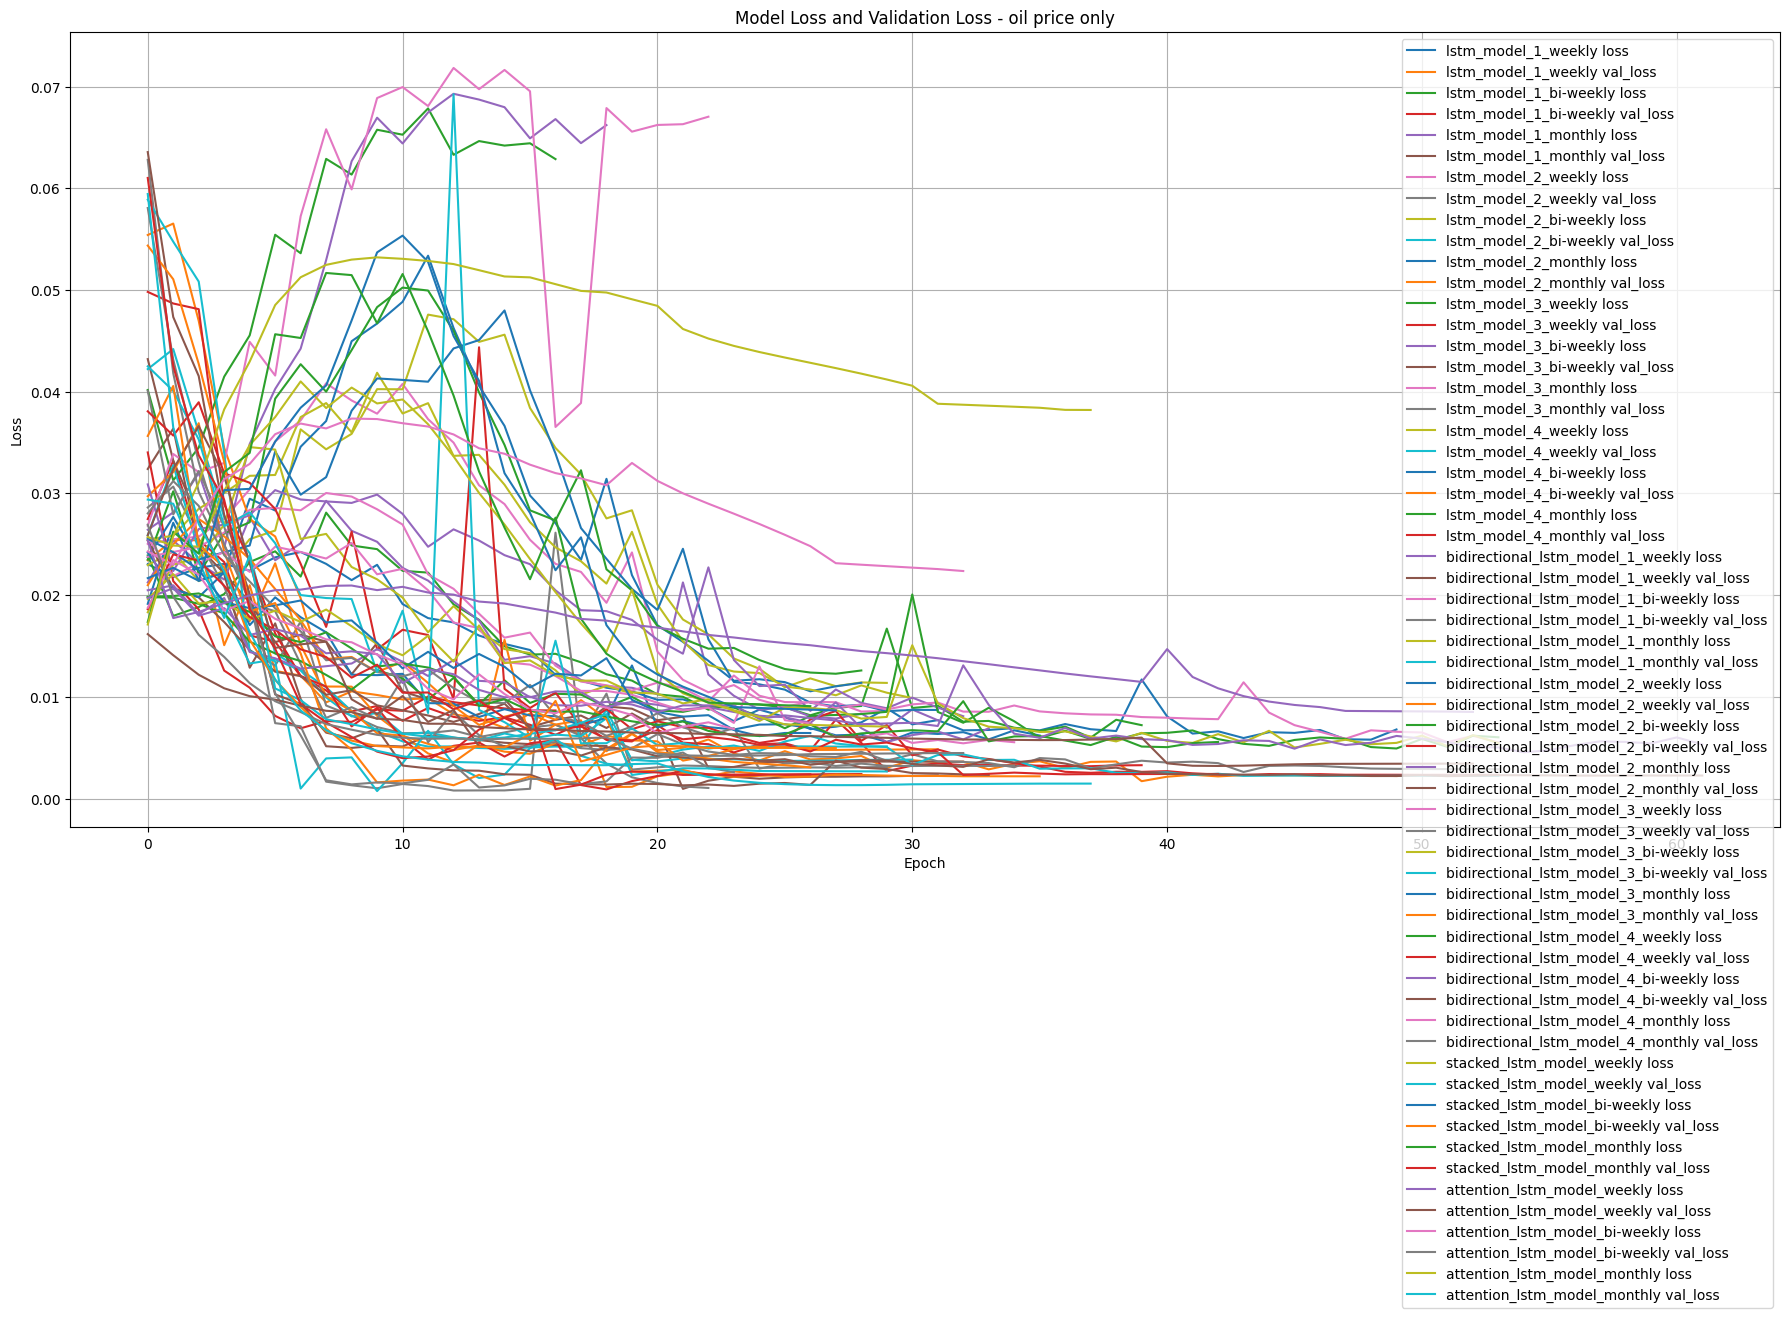

In [57]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Model Loss and Validation Loss - oil price only')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/LSTM model loss all models oil price only.png')

In [58]:
val_performance

{'lstm_model_1_weekly': {'loss': 0.0017033359035849571,
  'mean_absolute_percentage_error': 9.124899864196777,
  'mean_absolute_error': 0.032406285405159},
 'lstm_model_1_bi-weekly': {'loss': 0.0026833044830709696,
  'mean_absolute_percentage_error': 10.389863967895508,
  'mean_absolute_error': 0.03641559183597565},
 'lstm_model_1_monthly': {'loss': 0.0009482825989834964,
  'mean_absolute_percentage_error': 5.994137763977051,
  'mean_absolute_error': 0.02623942121863365},
 'lstm_model_2_weekly': {'loss': 0.002844341564923525,
  'mean_absolute_percentage_error': 11.591997146606445,
  'mean_absolute_error': 0.04052158072590828},
 'lstm_model_2_bi-weekly': {'loss': 0.0037454646080732346,
  'mean_absolute_percentage_error': 13.273645401000977,
  'mean_absolute_error': 0.04674583300948143},
 'lstm_model_2_monthly': {'loss': 0.00112302100751549,
  'mean_absolute_percentage_error': 6.12974214553833,
  'mean_absolute_error': 0.027948912233114243},
 'lstm_model_3_weekly': {'loss': 0.00690299691

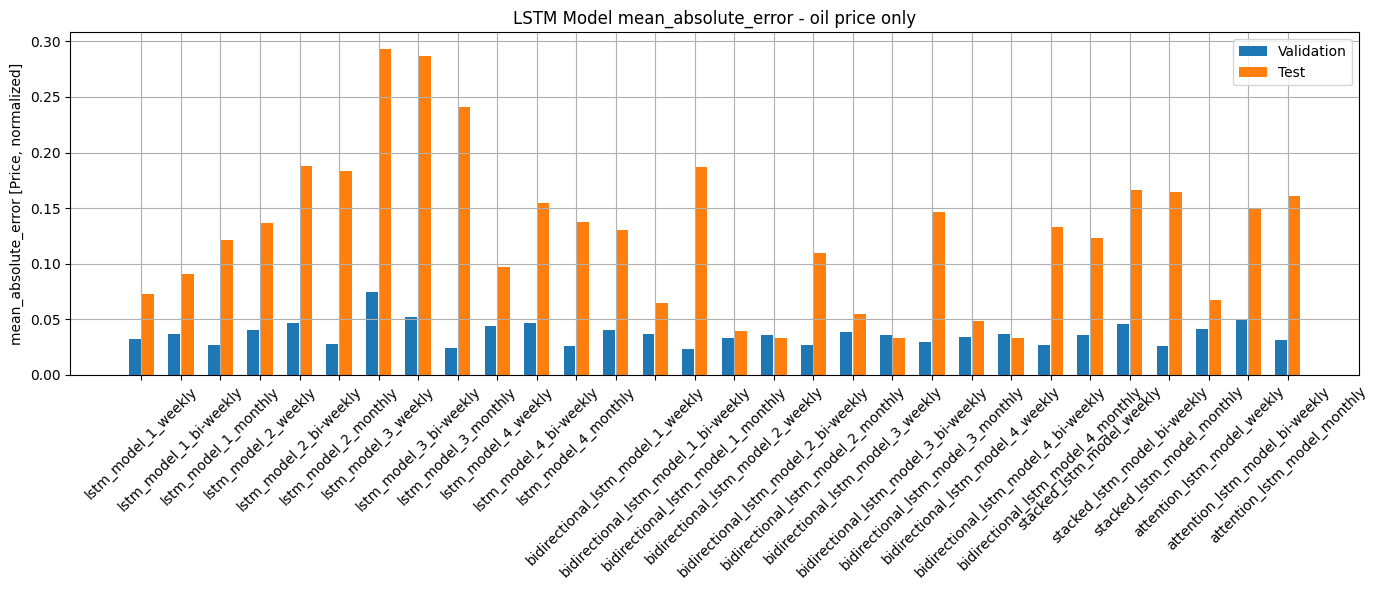

In [59]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_error - oil price only')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/LSTM mean_absolute_error all models oil price only.png')


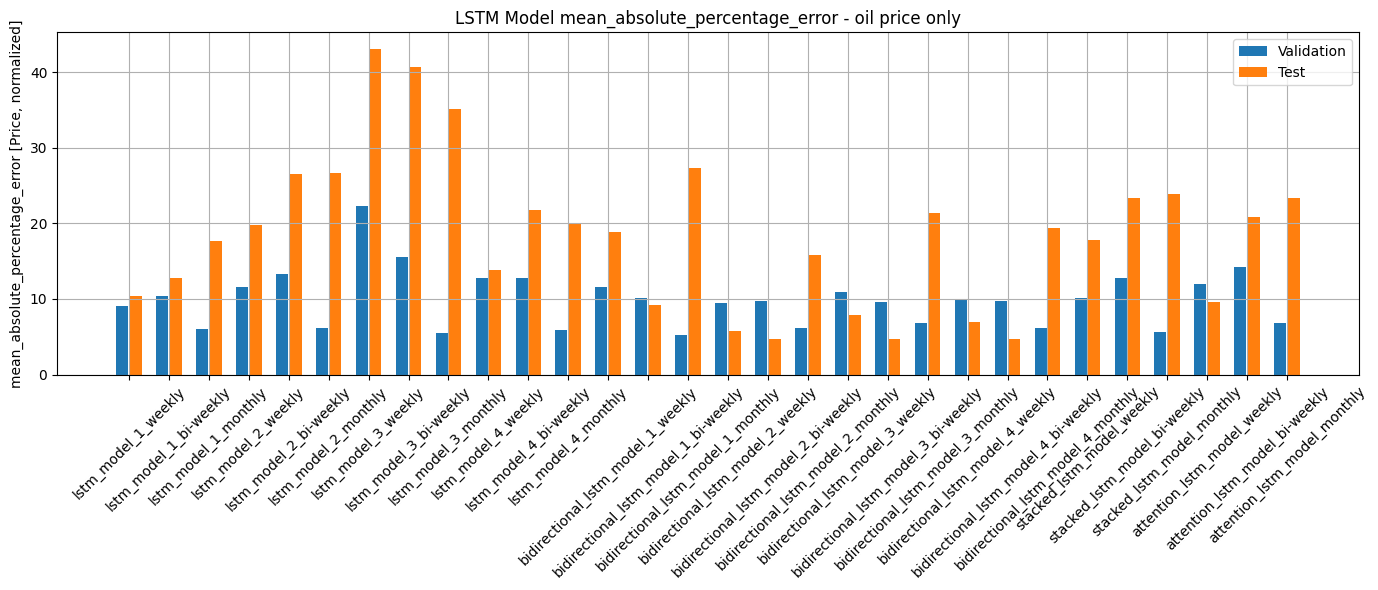

In [60]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_percentage_error - oil price only')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/LSTM mean_absolute_percentage_error all models oil price only.png')

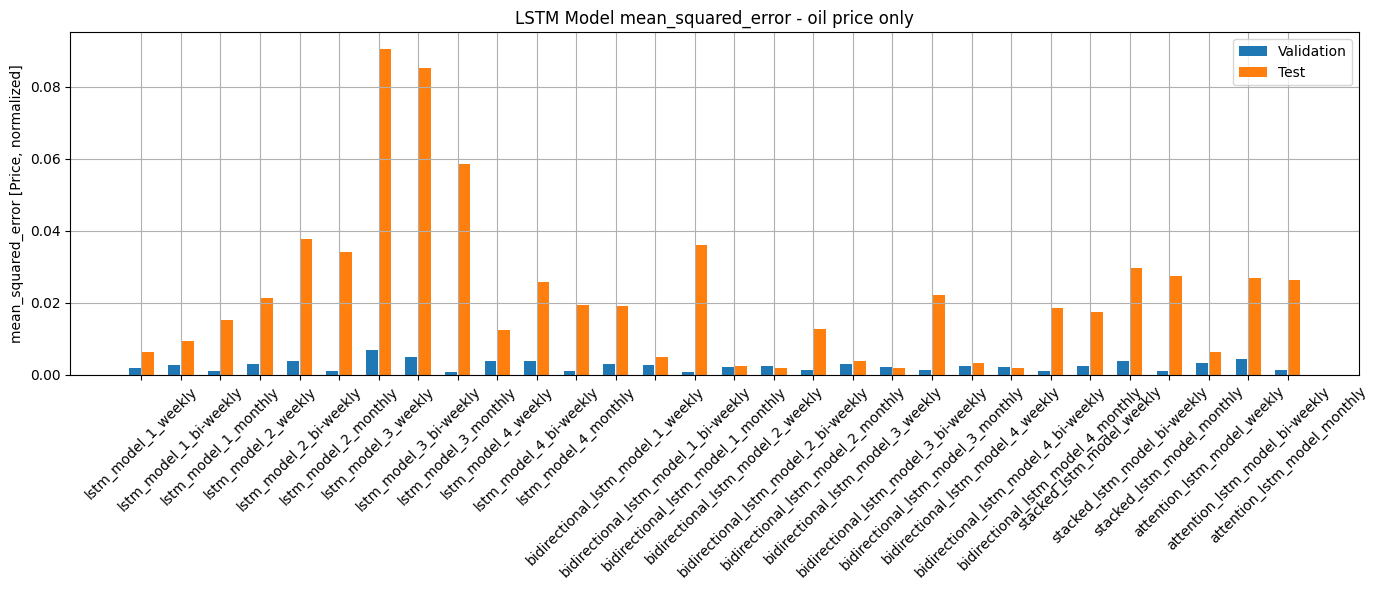

In [61]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_squared_error - oil price only')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil/LSTM mean_squared_error all models oil price only.png')

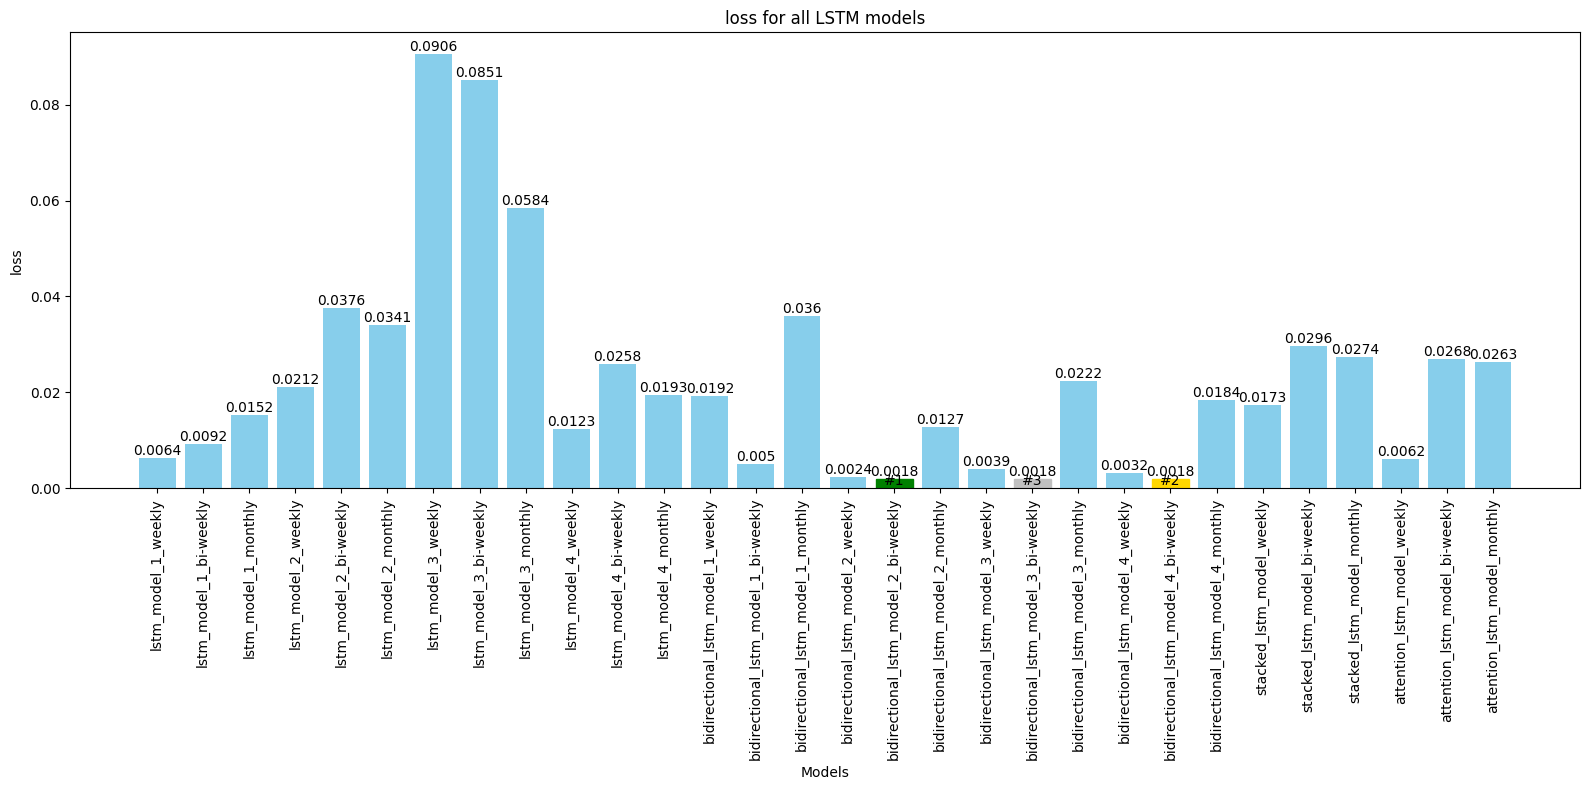

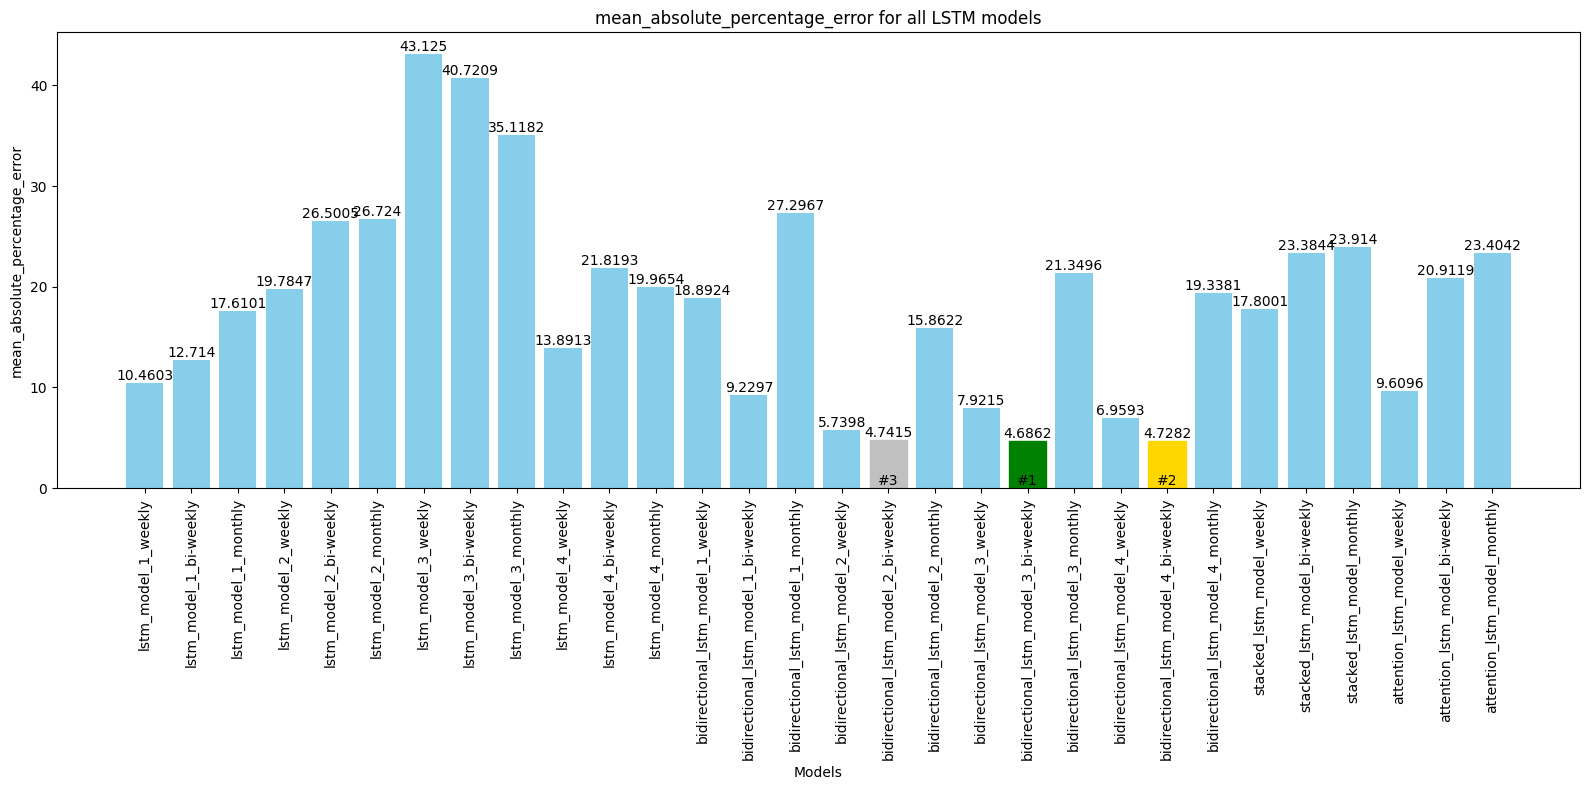

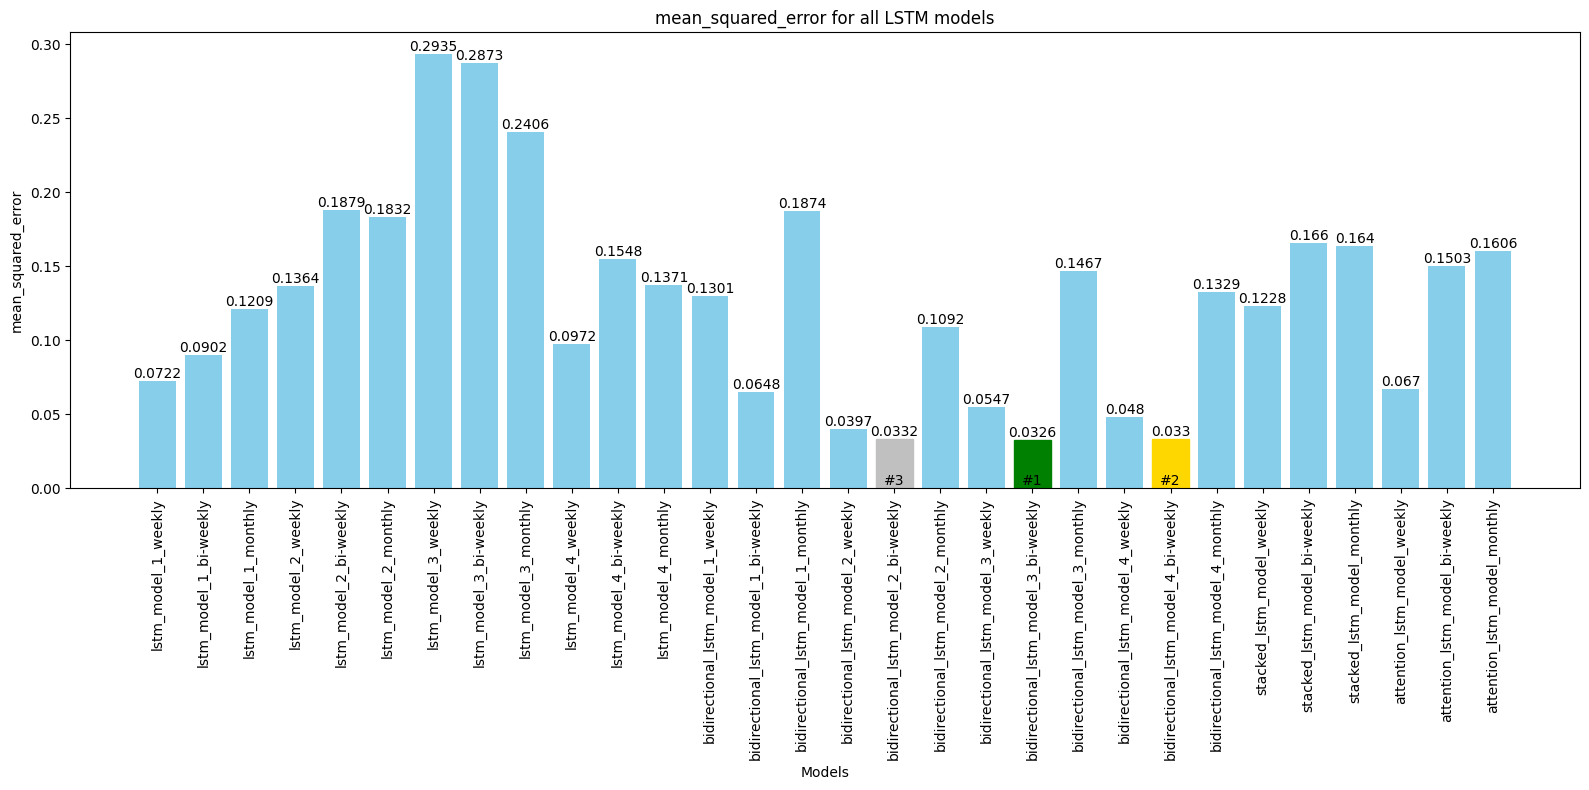

Top 3 models with minimum loss: ['bidirectional_lstm_model_2_bi-weekly', 'bidirectional_lstm_model_4_bi-weekly', 'bidirectional_lstm_model_3_bi-weekly']
Top 3 models with minimum mean_absolute_error: ['bidirectional_lstm_model_3_bi-weekly', 'bidirectional_lstm_model_4_bi-weekly', 'bidirectional_lstm_model_2_bi-weekly']
Top 3 models with minimum mean_squared_error: ['bidirectional_lstm_model_3_bi-weekly', 'bidirectional_lstm_model_4_bi-weekly', 'bidirectional_lstm_model_2_bi-weekly']


In [62]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all LSTM models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil/LSTM {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'loss', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_squared_error', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [63]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [64]:
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [65]:
seq_length

7

In [66]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

264/264 [==============================] - 2s 3ms/step
(264, 1)


In [67]:
all_predict[0]

array([0.5820025], dtype=float32)

264/264 [==============================] - 1s 2ms/step


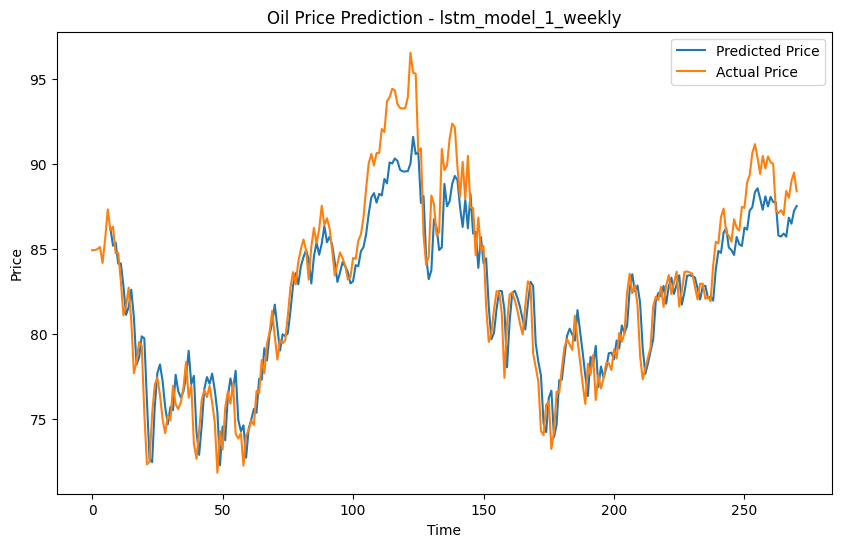

257/257 [==============================] - 2s 3ms/step


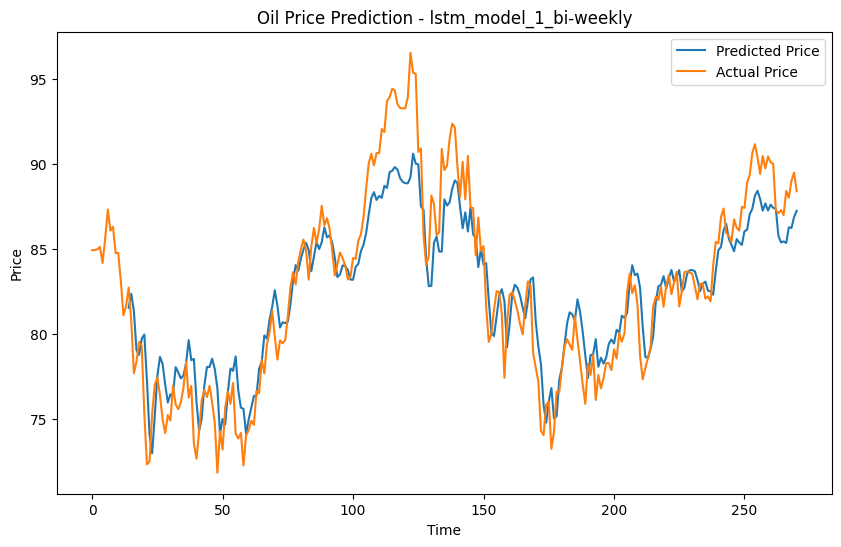

241/241 [==============================] - 2s 4ms/step


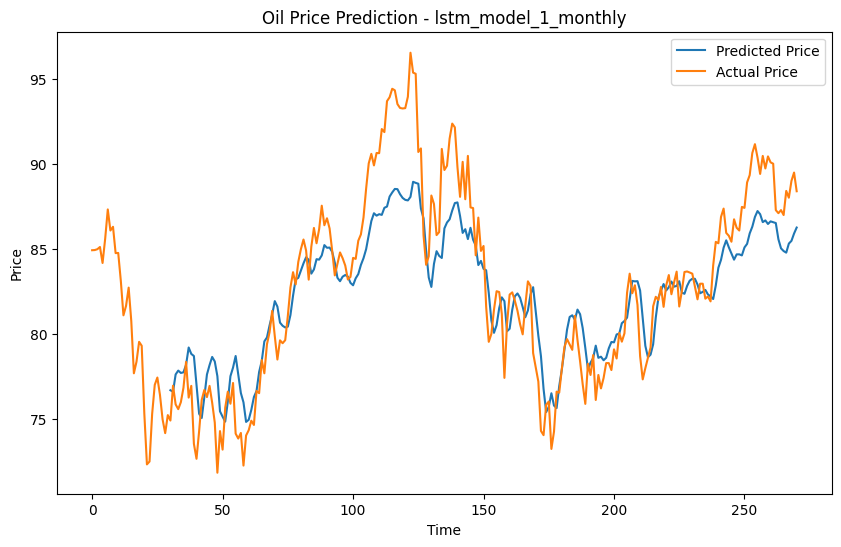

264/264 [==============================] - 2s 3ms/step


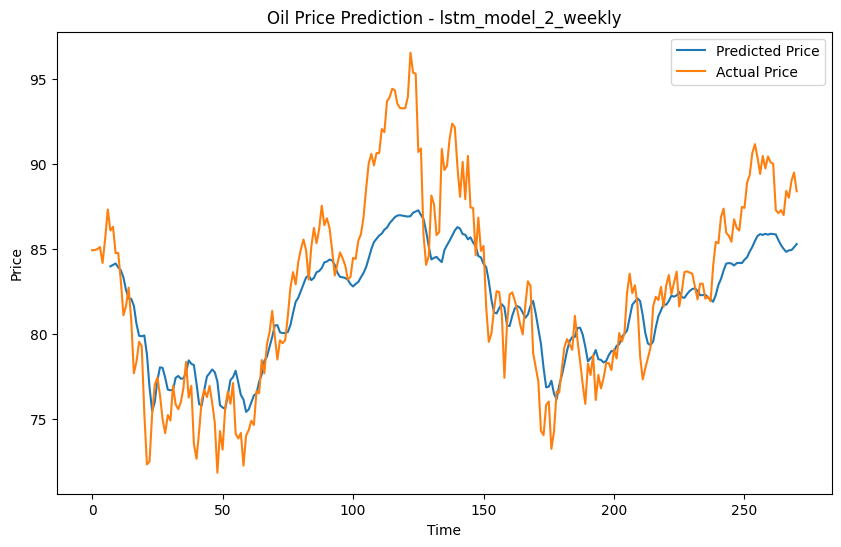

257/257 [==============================] - 3s 4ms/step


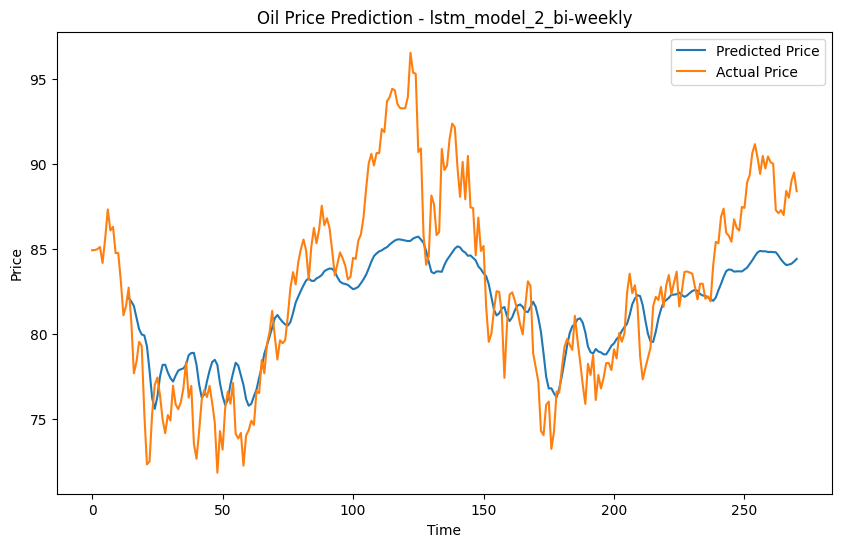

241/241 [==============================] - 3s 7ms/step


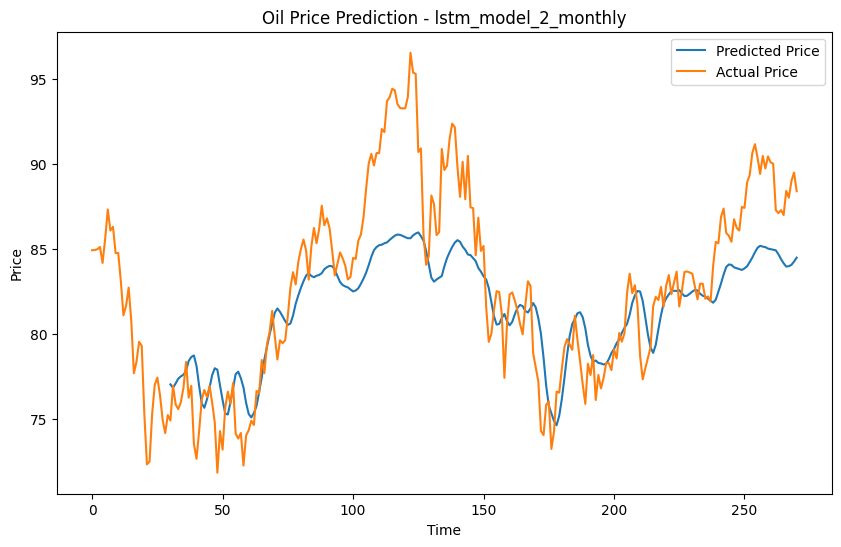

264/264 [==============================] - 4s 5ms/step


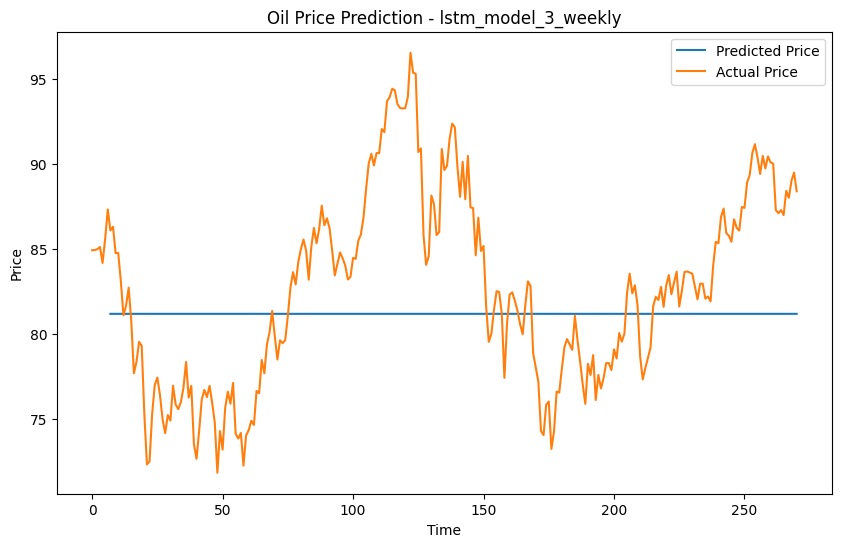

257/257 [==============================] - 7s 9ms/step


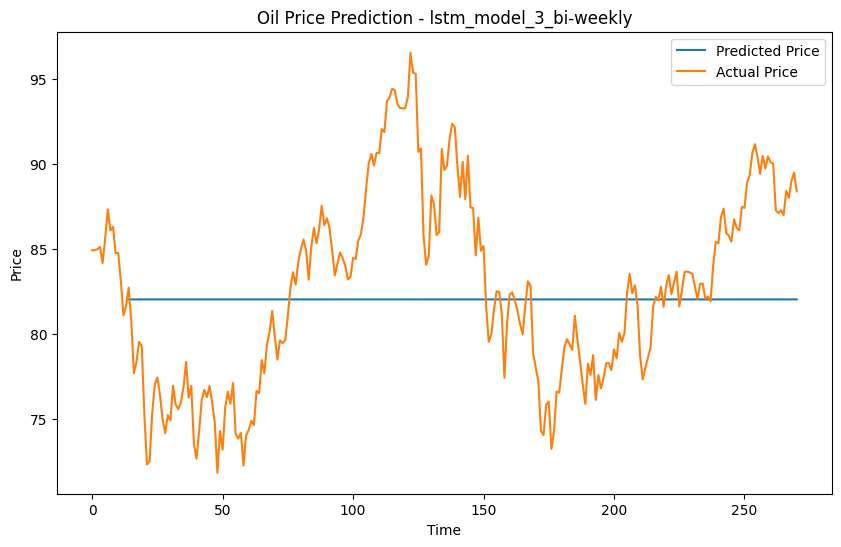

241/241 [==============================] - 6s 12ms/step


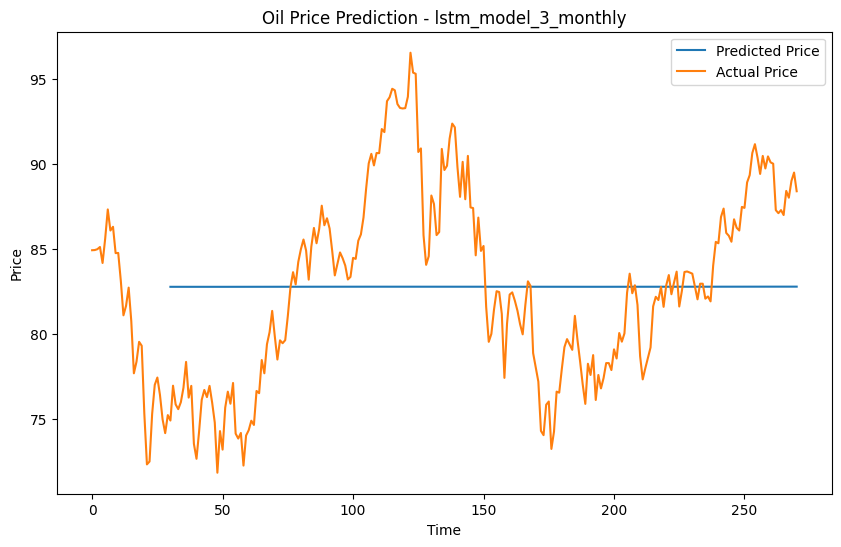

264/264 [==============================] - 3s 4ms/step


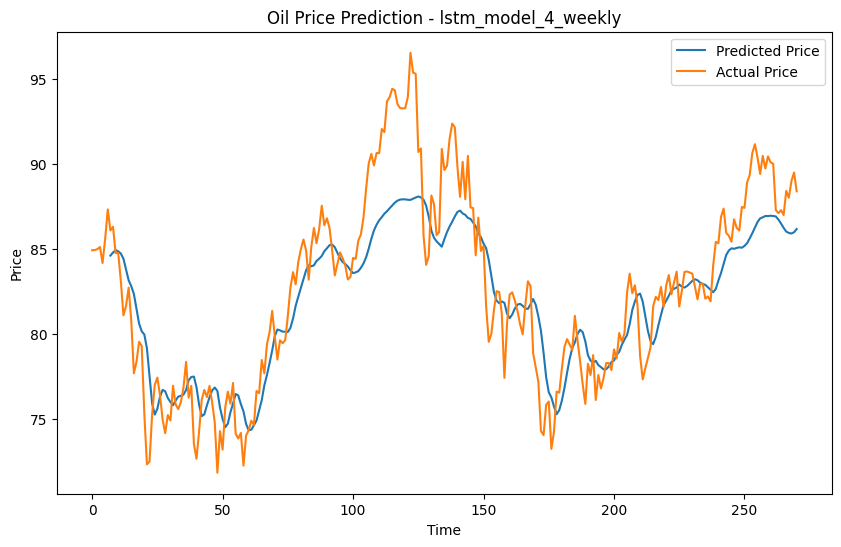

257/257 [==============================] - 3s 4ms/step


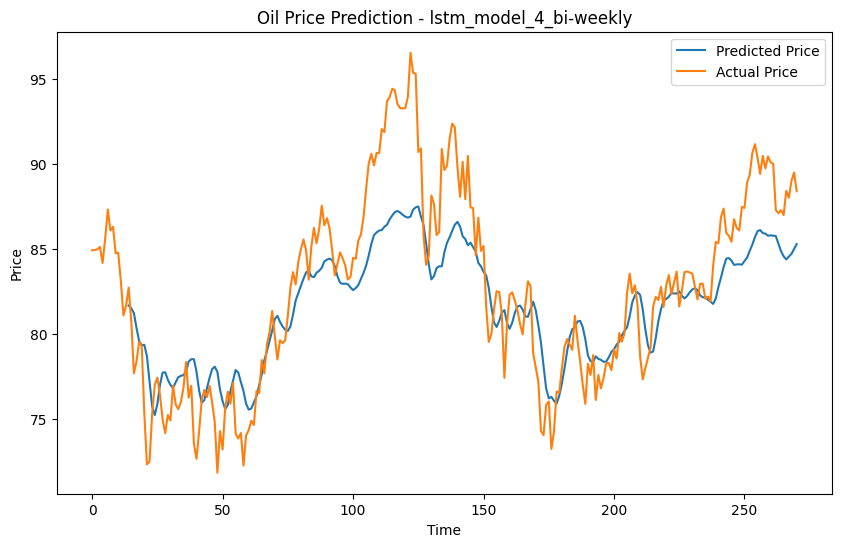

241/241 [==============================] - 4s 8ms/step


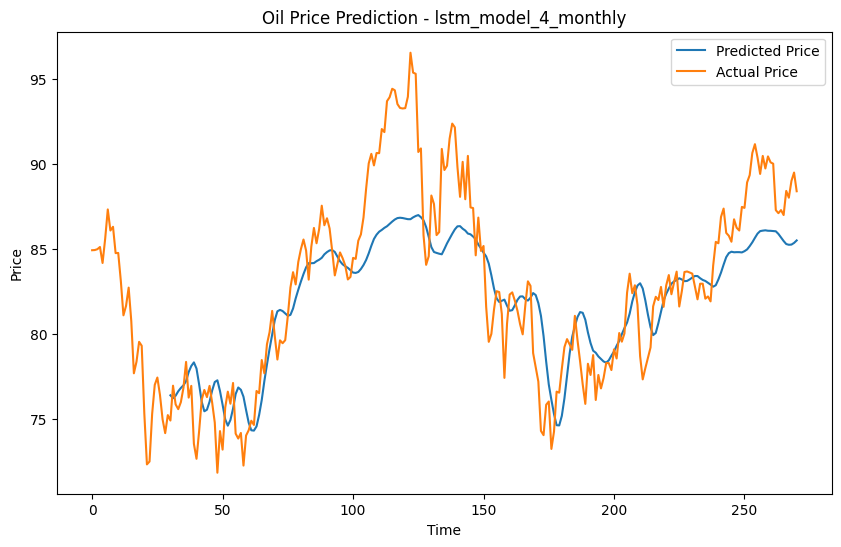

264/264 [==============================] - 6s 5ms/step


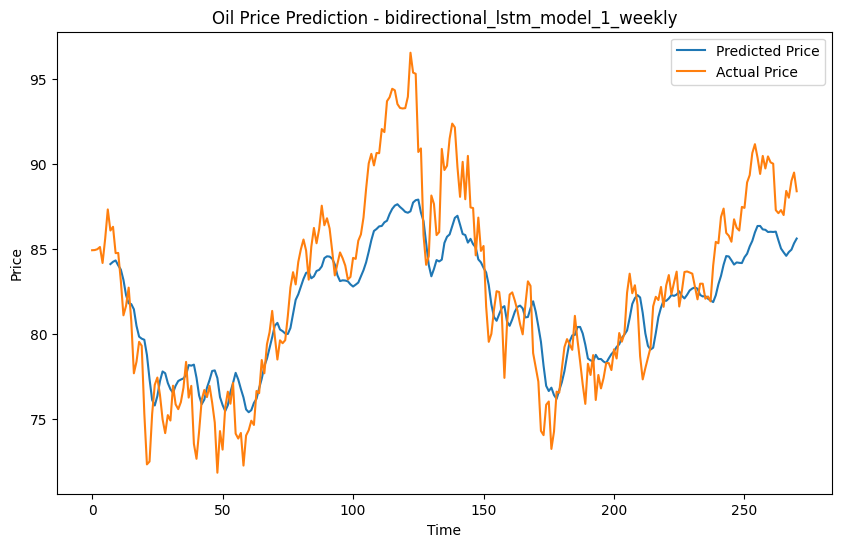

257/257 [==============================] - 5s 6ms/step


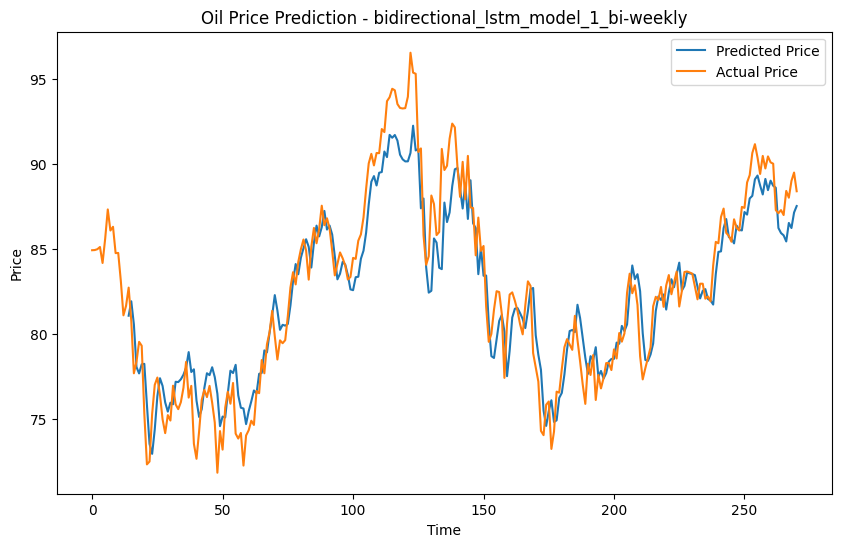

241/241 [==============================] - 5s 7ms/step


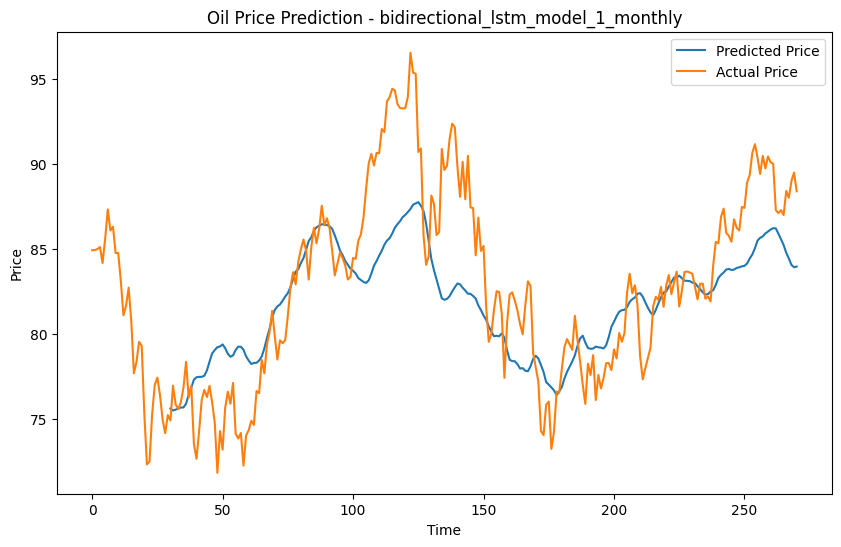

264/264 [==============================] - 3s 4ms/step


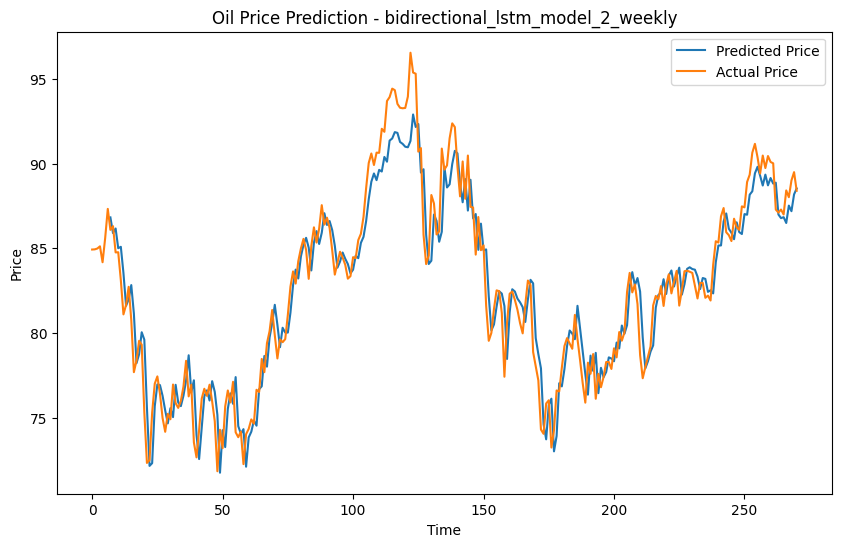

257/257 [==============================] - 3s 5ms/step


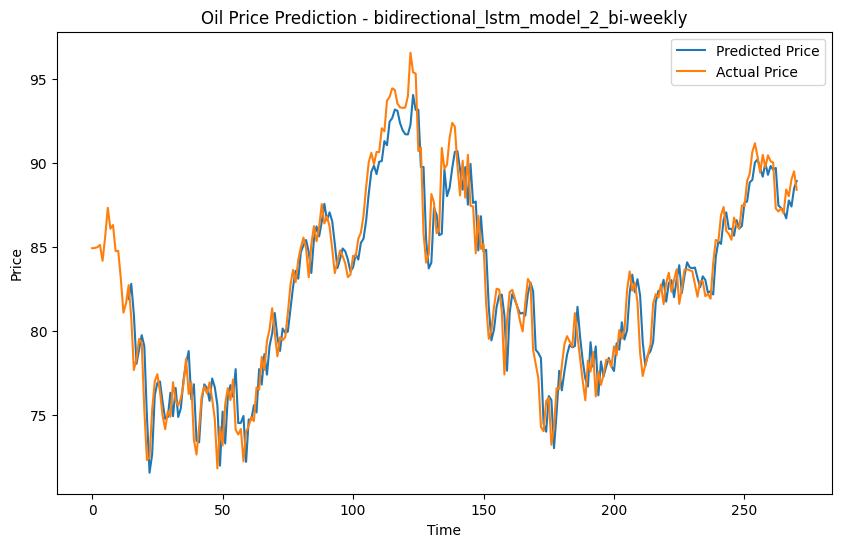

241/241 [==============================] - 4s 8ms/step


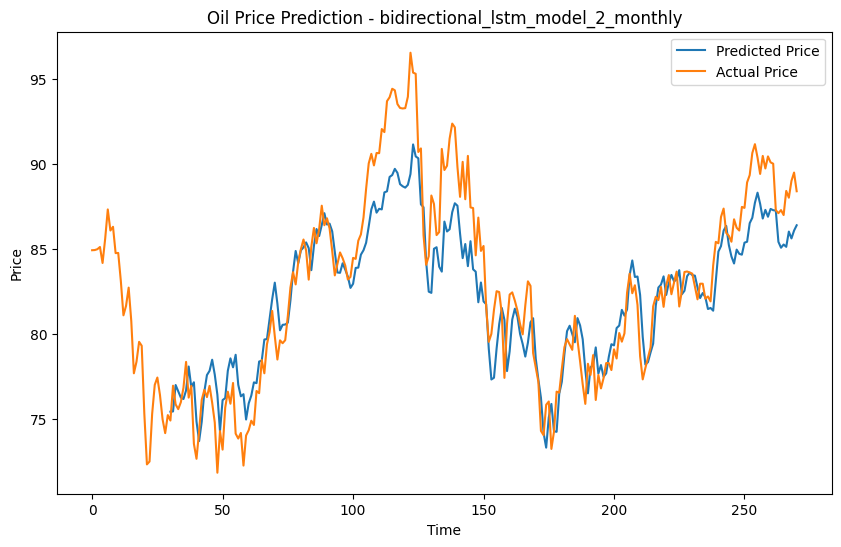

264/264 [==============================] - 4s 5ms/step


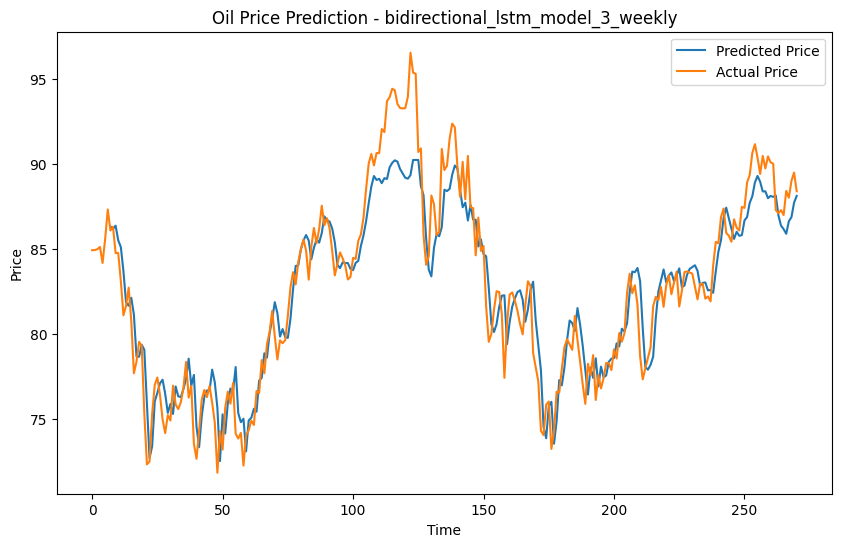

257/257 [==============================] - 4s 5ms/step


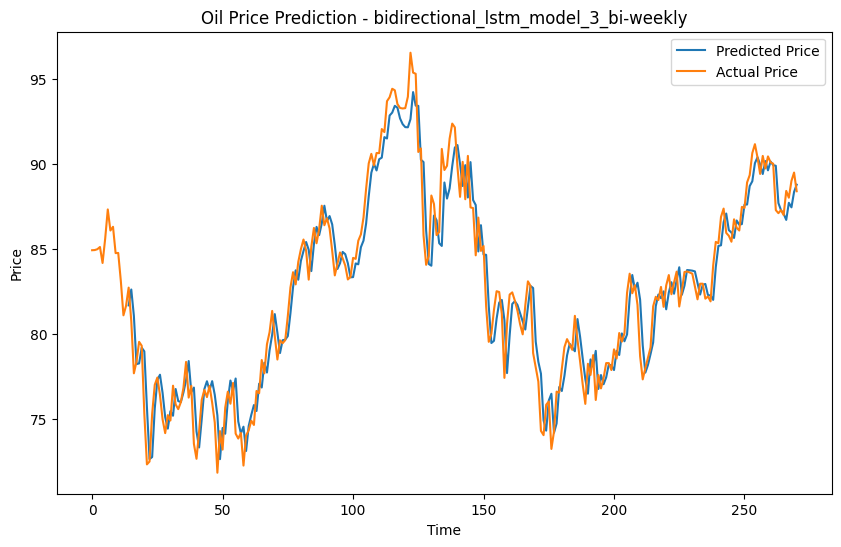

241/241 [==============================] - 5s 9ms/step


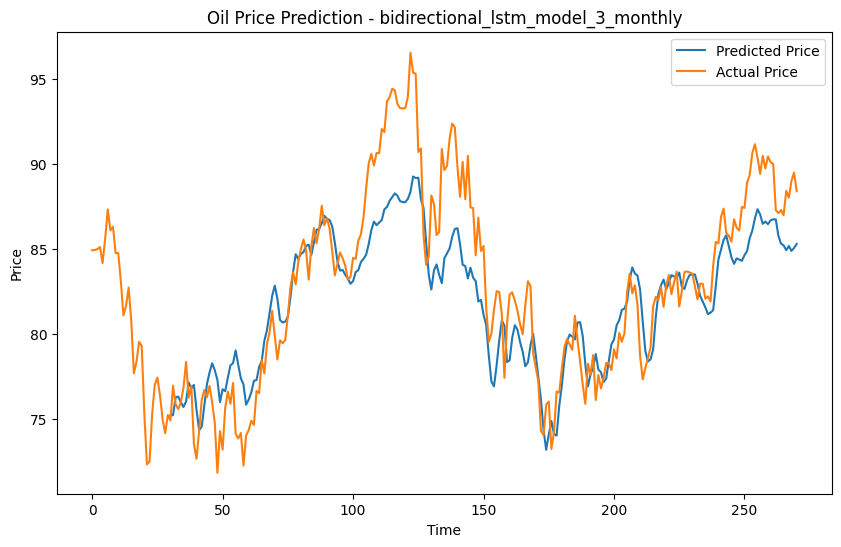

264/264 [==============================] - 3s 4ms/step


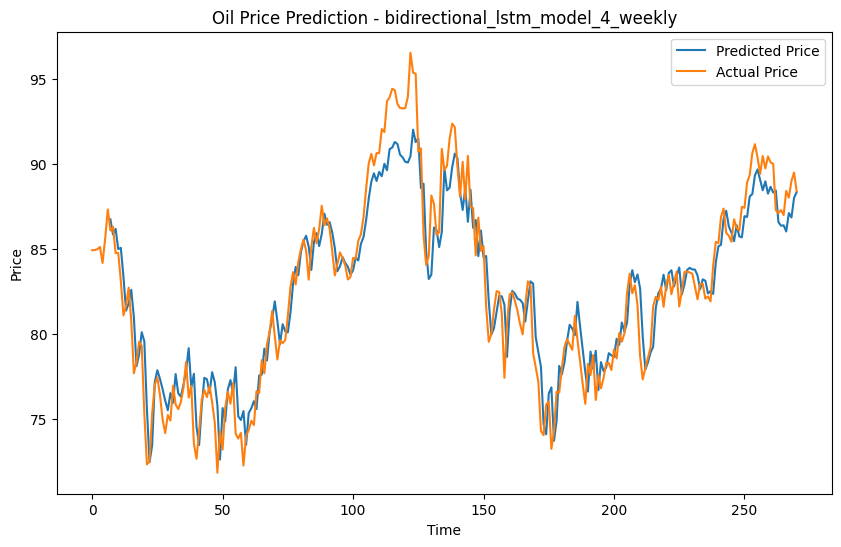

257/257 [==============================] - 3s 4ms/step


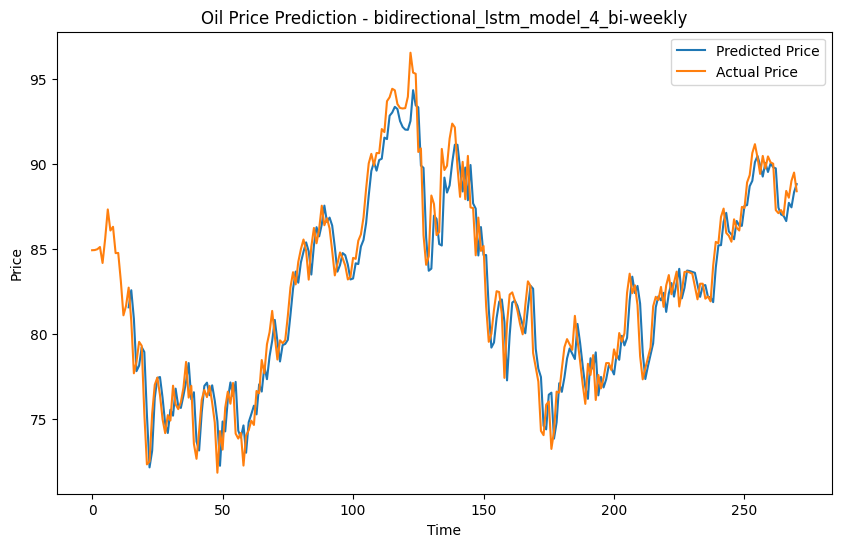

241/241 [==============================] - 4s 9ms/step


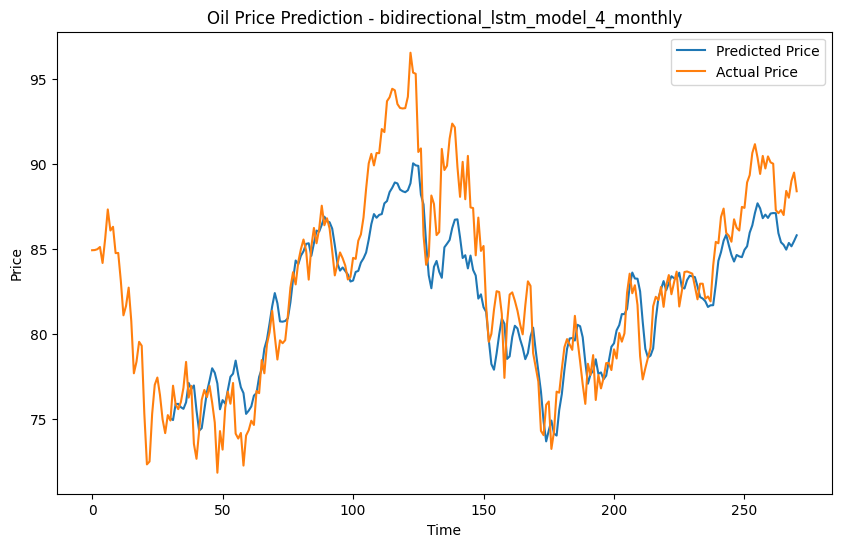

264/264 [==============================] - 2s 4ms/step


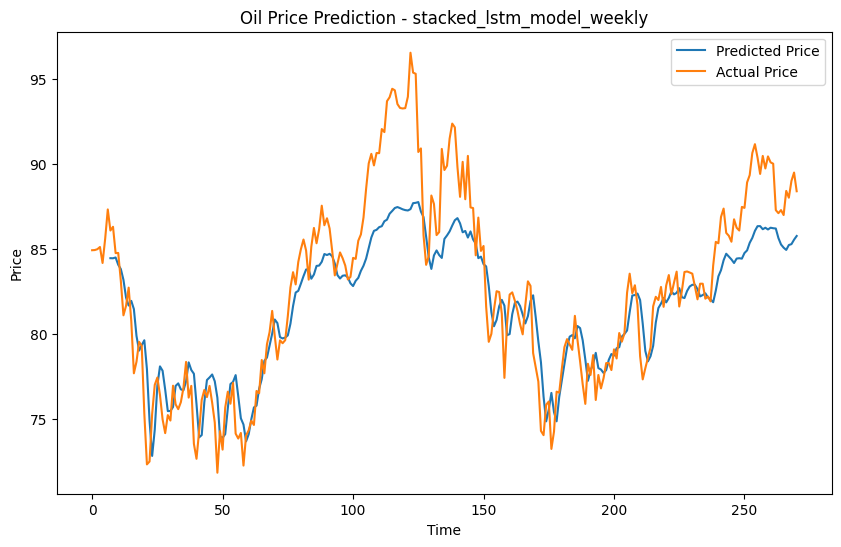

257/257 [==============================] - 3s 4ms/step


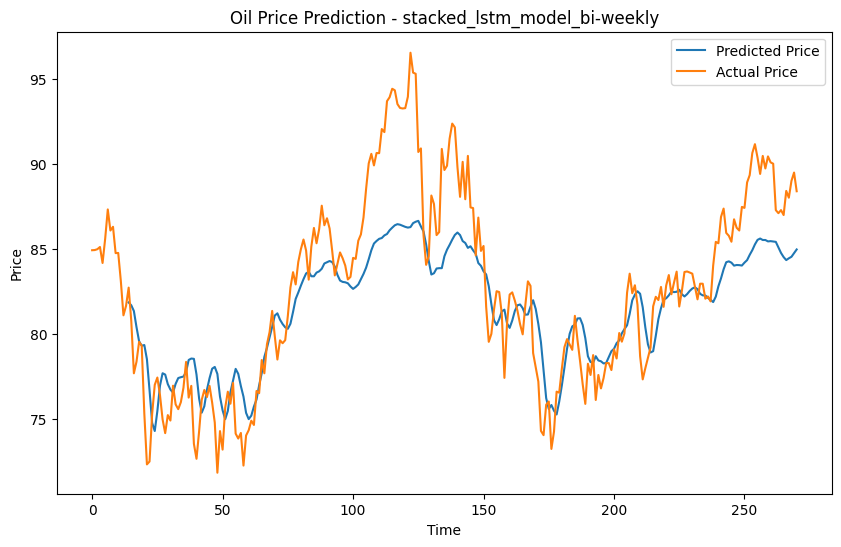

241/241 [==============================] - 3s 8ms/step


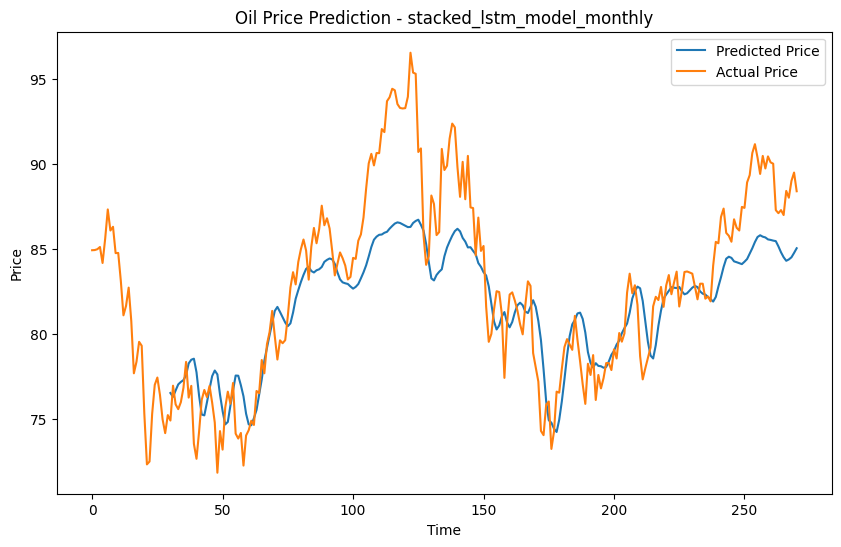

264/264 [==============================] - 1s 2ms/step
Error attention_lstm_model_weekly (264, 7, 1)
257/257 [==============================] - 1s 3ms/step
Error attention_lstm_model_bi-weekly (257, 14, 1)
241/241 [==============================] - 1s 4ms/step
Error attention_lstm_model_monthly (241, 30, 1)


In [68]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil/LSTM {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)

In [77]:
from itertools import product
# Grid search
# Define grid search parameters
patience_values = [5, 10, 15, 20]
restore_best_weights_values = [True, False]
reduce_lr_patience_values = [3, 5, 7]

In [88]:
def compile_and_fit_with_grid_search(model, window):
    results = []
    for early_patience, restore_best, lr_patience in product(patience_values, restore_best_weights_values, reduce_lr_patience_values):
        print(f"\n\n ------- early_patience: {early_patience}  restore_best: {restore_best} lr_patience:{lr_patience}")
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_patience, restore_best_weights=restore_best)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=lr_patience)
        callbacks = [early_stopping, reduce_lr]

        model.compile(
            # loss='mean_absolute_percentage_error',
            loss= tf.keras.losses.MeanSquaredError(),
            optimizer='adam',
            metrics=[
            tf.keras.metrics.MeanAbsolutePercentageError(),
            # tf.keras.metrics.MeanSquaredError()
            tf.keras.metrics.MeanAbsoluteError(),
            ]
        )

        history = model.fit(
            window.train, 
            epochs=MAX_EPOCHS, 
            validation_data=window.val,
            callbacks=callbacks
        )

        result = {
            'early_patience': early_patience,
            'restore_best_weights': restore_best,
            'reduce_lr_patience': lr_patience,
            'val_loss': history.history['val_loss'],
            'final_val_loss': history.history['val_loss'][-1]
        }
        results.append(result)
        all_predict = model.predict(window.all_data)
        try:

            X_all_data = scaler.inverse_transform(all_predict)

            plt.figure(figsize=(10, 6))
            plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
            plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
            plt.title(f'Oil Price Prediction - {model_name}')
            plt.xlabel('Time')
            plt.ylabel('Price')
            plt.legend()
            # plt.savefig(f'outputs/oil/LSTM {model_name} Oil Price Prediction.png')
            plt.show()
        except:
            print("Error", model_name, all_predict.shape)
    return results
        

In [89]:
model_name='bidirectional_lstm_model_2_bi-weekly'
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']



 ------- early_patience: 5  restore_best: True lr_patience:3
Epoch 1/100
175/175 [==============================] - 9s 16ms/step - loss: 0.0036 - mean_absolute_percentage_error: 602358.5625 - mean_absolute_error: 0.0483 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 14.9728 - val_mean_absolute_error: 0.0572 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_percentage_error: 694581.1875 - mean_absolute_error: 0.0455 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 14.6252 - val_mean_absolute_error: 0.0573 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_percentage_error: 700795.3750 - mean_absolute_error: 0.0471 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 13.4389 - val_mean_absolute_error: 0.0511 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_percentage_error: 846623.062

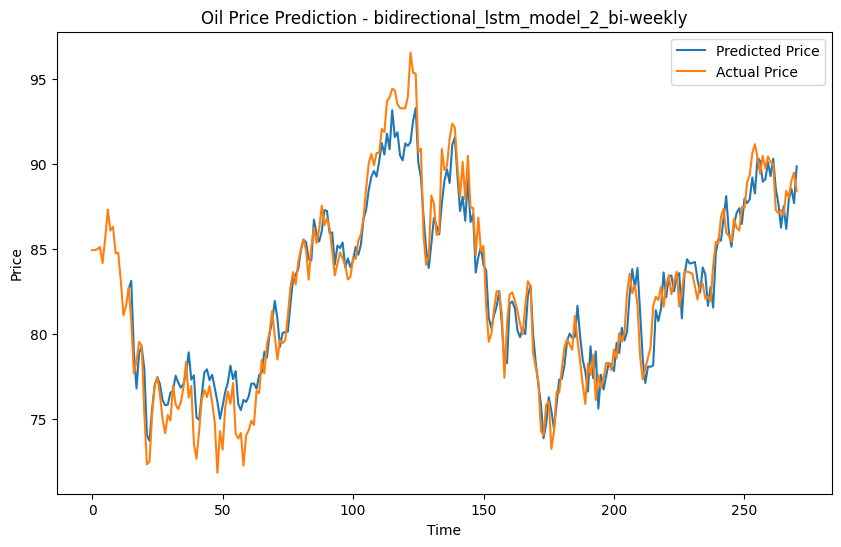



 ------- early_patience: 5  restore_best: True lr_patience:5
Epoch 1/100
175/175 [==============================] - 9s 17ms/step - loss: 0.0032 - mean_absolute_percentage_error: 547025.7500 - mean_absolute_error: 0.0450 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 15.7016 - val_mean_absolute_error: 0.0607 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_percentage_error: 674042.6875 - mean_absolute_error: 0.0483 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 13.6614 - val_mean_absolute_error: 0.0503 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_percentage_error: 1054547.2500 - mean_absolute_error: 0.0447 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 19.9567 - val_mean_absolute_error: 0.0749 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0038 - mean_absolute_percentage_error: 905405.62

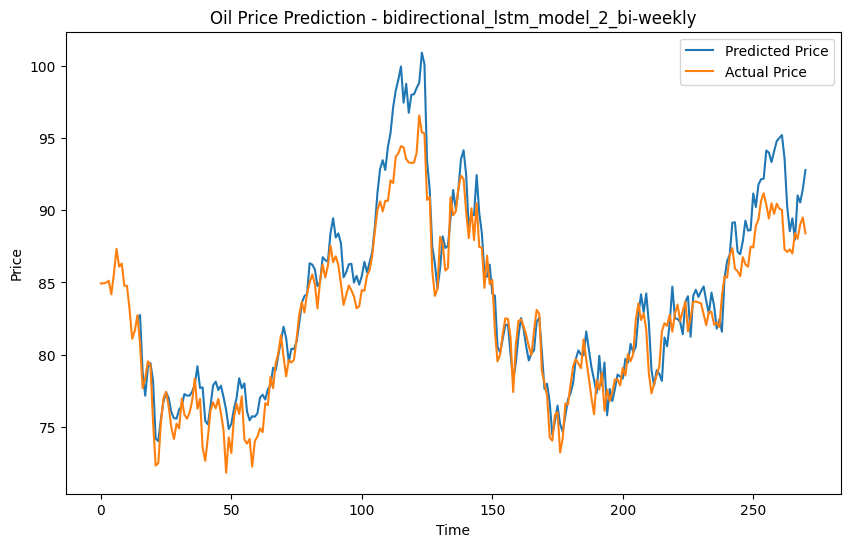



 ------- early_patience: 5  restore_best: True lr_patience:7
Epoch 1/100
175/175 [==============================] - 9s 15ms/step - loss: 0.0034 - mean_absolute_percentage_error: 637744.8750 - mean_absolute_error: 0.0459 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 13.4273 - val_mean_absolute_error: 0.0511 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_percentage_error: 1047852.4375 - mean_absolute_error: 0.0479 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 12.9397 - val_mean_absolute_error: 0.0493 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_percentage_error: 790397.4375 - mean_absolute_error: 0.0476 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 14.6615 - val_mean_absolute_error: 0.0555 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_percentage_error: 979231.18

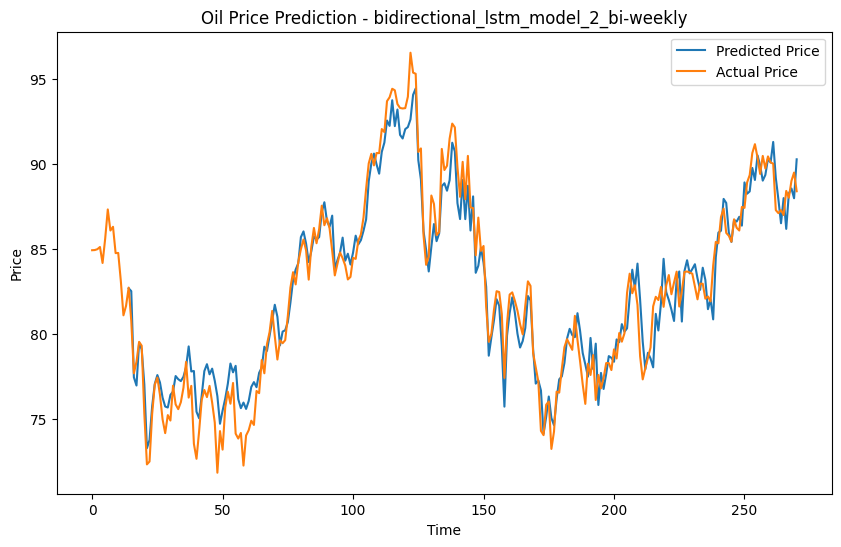



 ------- early_patience: 5  restore_best: False lr_patience:3
Epoch 1/100
175/175 [==============================] - 9s 16ms/step - loss: 0.0032 - mean_absolute_percentage_error: 625081.5625 - mean_absolute_error: 0.0445 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 15.6189 - val_mean_absolute_error: 0.0592 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0033 - mean_absolute_percentage_error: 677697.0625 - mean_absolute_error: 0.0453 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 18.4502 - val_mean_absolute_error: 0.0694 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_percentage_error: 796754.9375 - mean_absolute_error: 0.0465 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 14.0841 - val_mean_absolute_error: 0.0531 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_absolute_percentage_error: 613868.6

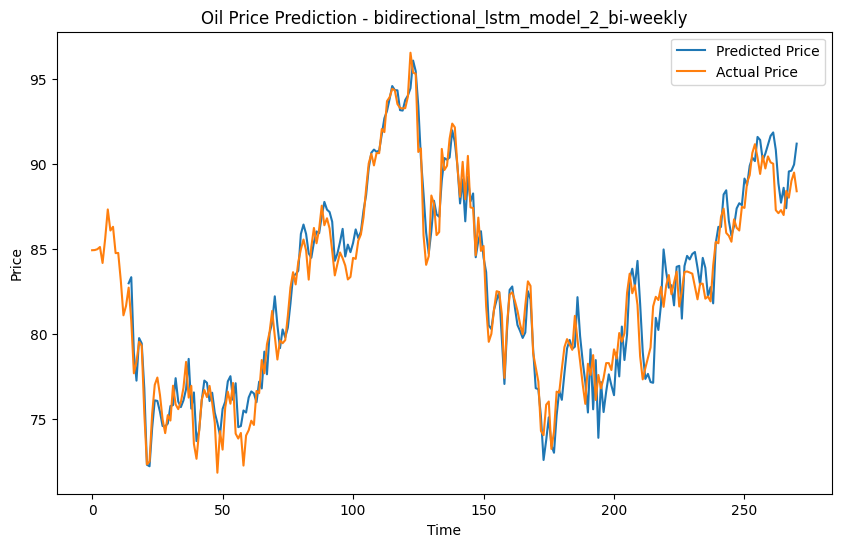



 ------- early_patience: 5  restore_best: False lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 15ms/step - loss: 0.0032 - mean_absolute_percentage_error: 646140.3125 - mean_absolute_error: 0.0438 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 15.5780 - val_mean_absolute_error: 0.0570 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_percentage_error: 578719.7500 - mean_absolute_error: 0.0469 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 14.8131 - val_mean_absolute_error: 0.0557 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0033 - mean_absolute_percentage_error: 599439.5000 - mean_absolute_error: 0.0456 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 13.8525 - val_mean_absolute_error: 0.0530 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0035 - mean_absolute_percentage_error: 723929.9

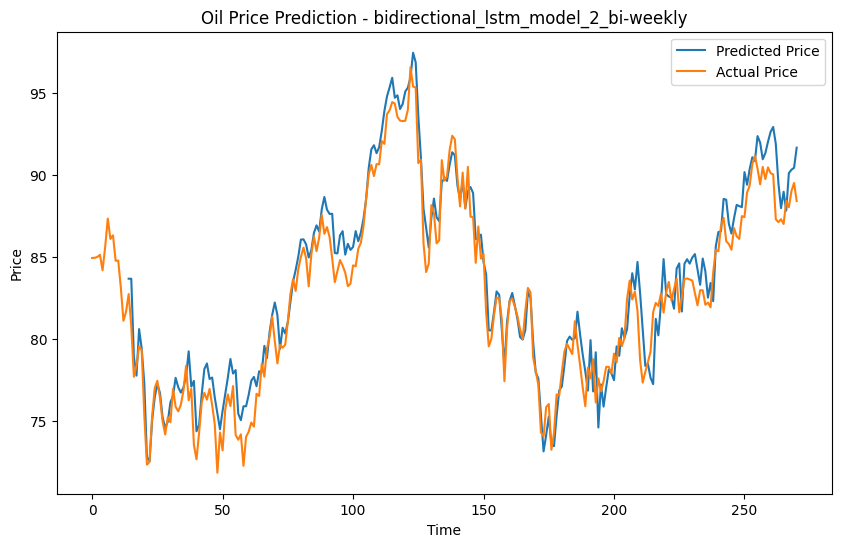



 ------- early_patience: 5  restore_best: False lr_patience:7
Epoch 1/100
175/175 [==============================] - 9s 15ms/step - loss: 0.0034 - mean_absolute_percentage_error: 705558.1875 - mean_absolute_error: 0.0449 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 15.1265 - val_mean_absolute_error: 0.0579 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_percentage_error: 417000.0938 - mean_absolute_error: 0.0444 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 13.1620 - val_mean_absolute_error: 0.0491 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0026 - mean_absolute_percentage_error: 324713.7500 - mean_absolute_error: 0.0411 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 17.9740 - val_mean_absolute_error: 0.0685 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0029 - mean_absolute_percentage_error: 616457.93

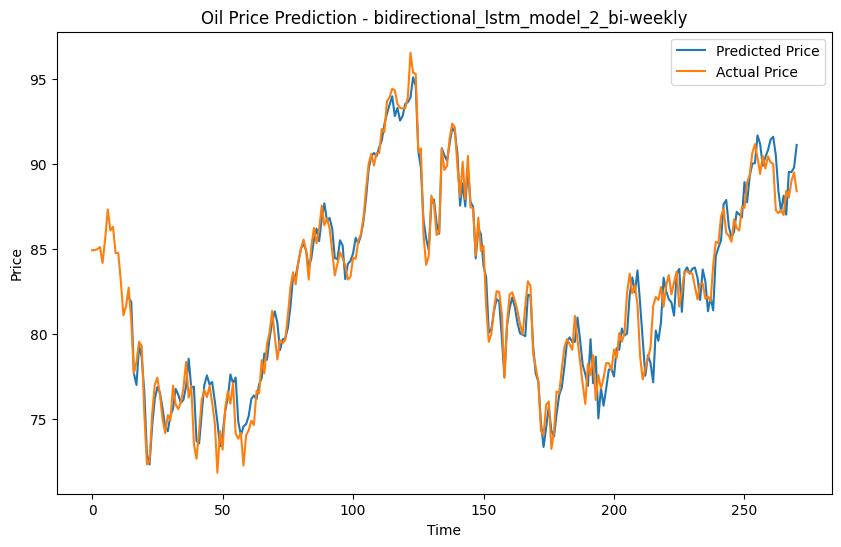



 ------- early_patience: 10  restore_best: True lr_patience:3
Epoch 1/100
175/175 [==============================] - 9s 14ms/step - loss: 0.0023 - mean_absolute_percentage_error: 512990.5938 - mean_absolute_error: 0.0382 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 16.6211 - val_mean_absolute_error: 0.0651 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0031 - mean_absolute_percentage_error: 880897.7500 - mean_absolute_error: 0.0450 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 15.4179 - val_mean_absolute_error: 0.0578 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_absolute_percentage_error: 612852.9375 - mean_absolute_error: 0.0396 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 15.9347 - val_mean_absolute_error: 0.0605 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0029 - mean_absolute_percentage_error: 800287.43

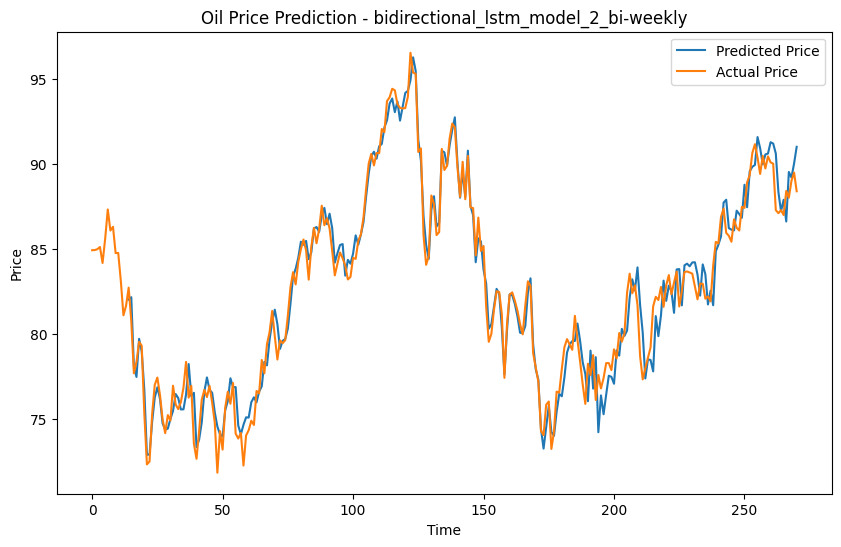



 ------- early_patience: 10  restore_best: True lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0028 - mean_absolute_percentage_error: 773380.0000 - mean_absolute_error: 0.0434 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 17.3109 - val_mean_absolute_error: 0.0669 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0027 - mean_absolute_percentage_error: 777957.8750 - mean_absolute_error: 0.0391 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 14.5446 - val_mean_absolute_error: 0.0545 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0030 - mean_absolute_percentage_error: 534494.8125 - mean_absolute_error: 0.0448 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 14.8680 - val_mean_absolute_error: 0.0549 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_percentage_error: 892146.

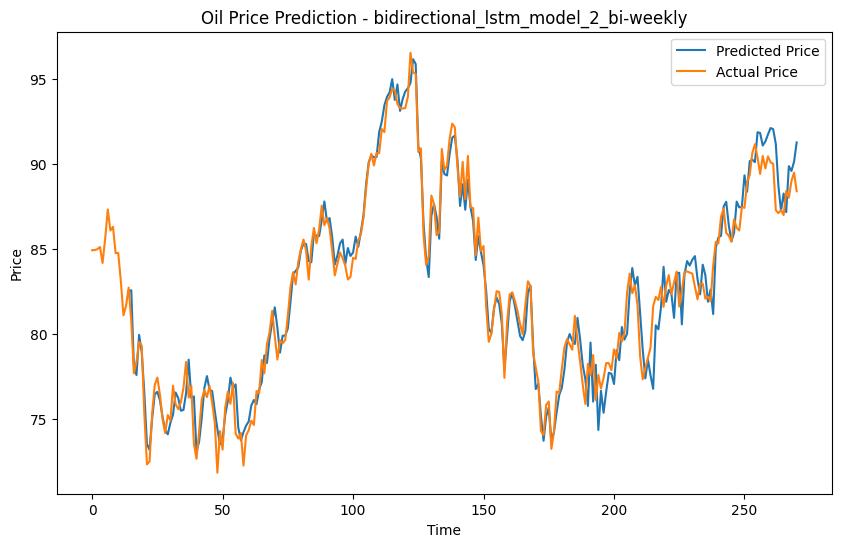



 ------- early_patience: 10  restore_best: True lr_patience:7
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0029 - mean_absolute_percentage_error: 807964.2500 - mean_absolute_error: 0.0424 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 14.3811 - val_mean_absolute_error: 0.0571 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0023 - mean_absolute_percentage_error: 534827.8125 - mean_absolute_error: 0.0397 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 18.6494 - val_mean_absolute_error: 0.0714 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 1006405.0000 - mean_absolute_error: 0.0373 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 17.0669 - val_mean_absolute_error: 0.0658 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0029 - mean_absolute_percentage_error: 64117

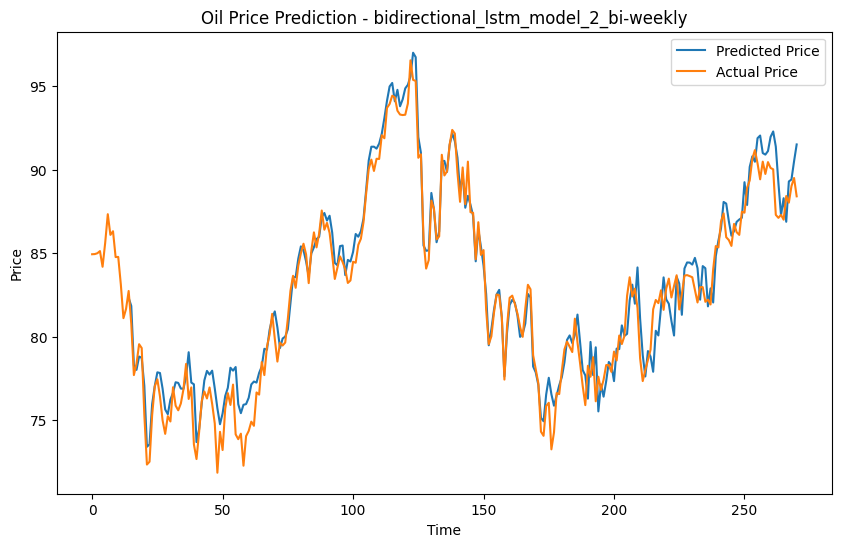



 ------- early_patience: 10  restore_best: False lr_patience:3
Epoch 1/100
175/175 [==============================] - 16s 14ms/step - loss: 0.0029 - mean_absolute_percentage_error: 494353.8438 - mean_absolute_error: 0.0423 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 15.7137 - val_mean_absolute_error: 0.0603 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0021 - mean_absolute_percentage_error: 705023.5625 - mean_absolute_error: 0.0362 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 16.6774 - val_mean_absolute_error: 0.0646 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_absolute_percentage_error: 754292.5625 - mean_absolute_error: 0.0421 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 13.7253 - val_mean_absolute_error: 0.0550 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0026 - mean_absolute_percentage_error: 604051.

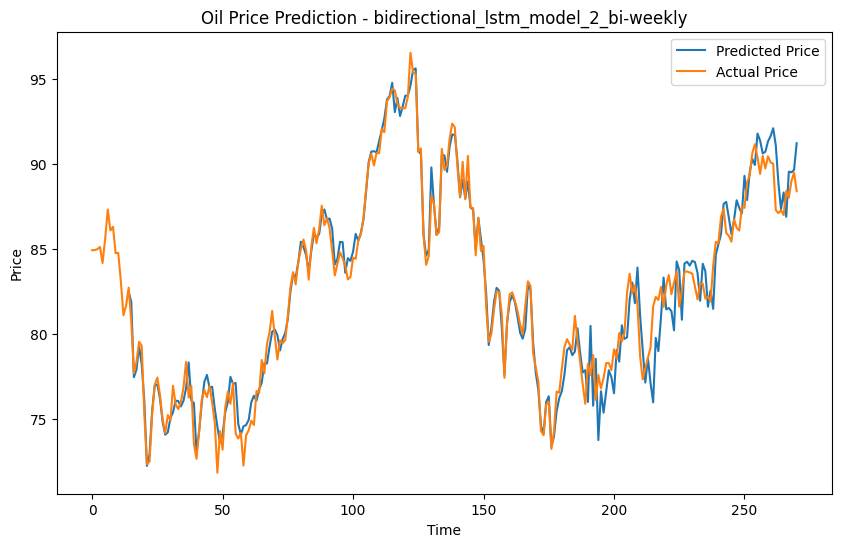



 ------- early_patience: 10  restore_best: False lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 17ms/step - loss: 0.0021 - mean_absolute_percentage_error: 425747.1875 - mean_absolute_error: 0.0367 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 17.8198 - val_mean_absolute_error: 0.0670 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_absolute_percentage_error: 733994.8125 - mean_absolute_error: 0.0391 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 15.5509 - val_mean_absolute_error: 0.0616 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_percentage_error: 676311.4375 - mean_absolute_error: 0.0391 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 14.7657 - val_mean_absolute_error: 0.0586 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0027 - mean_absolute_percentage_error: 948021.

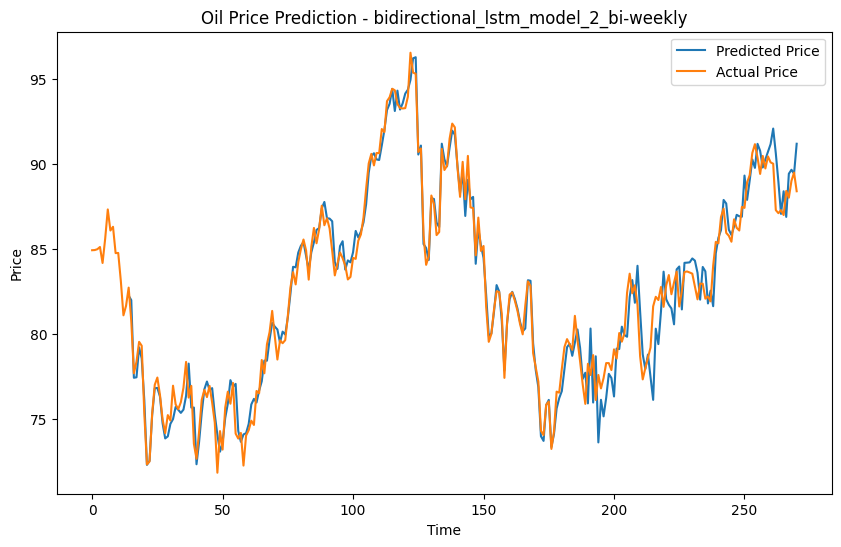



 ------- early_patience: 10  restore_best: False lr_patience:7
Epoch 1/100
175/175 [==============================] - 10s 17ms/step - loss: 0.0018 - mean_absolute_percentage_error: 886182.3125 - mean_absolute_error: 0.0330 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 15.3043 - val_mean_absolute_error: 0.0578 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0023 - mean_absolute_percentage_error: 668443.1875 - mean_absolute_error: 0.0372 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 16.4940 - val_mean_absolute_error: 0.0627 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0021 - mean_absolute_percentage_error: 537410.3750 - mean_absolute_error: 0.0363 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 19.6677 - val_mean_absolute_error: 0.0754 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0028 - mean_absolute_percentage_error: 78158

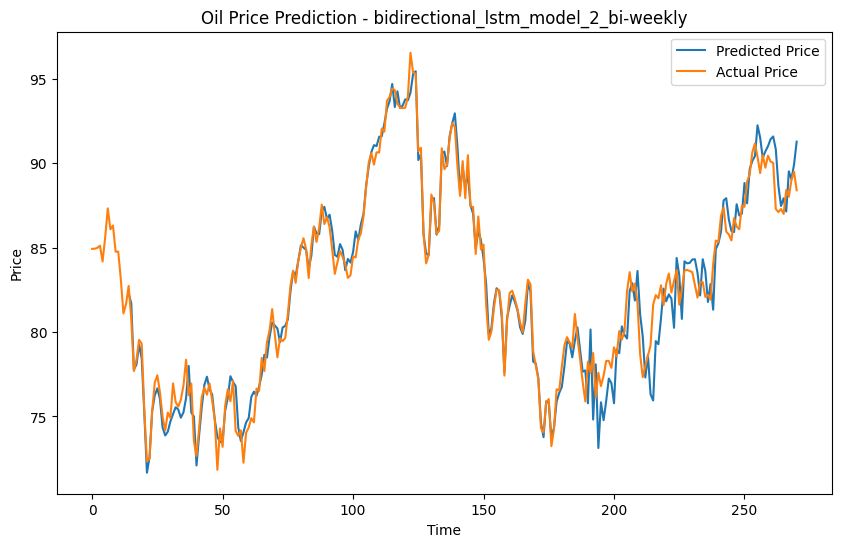



 ------- early_patience: 15  restore_best: True lr_patience:3
Epoch 1/100
175/175 [==============================] - 11s 19ms/step - loss: 0.0022 - mean_absolute_percentage_error: 701508.6875 - mean_absolute_error: 0.0375 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 15.6023 - val_mean_absolute_error: 0.0588 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0017 - mean_absolute_percentage_error: 653631.5625 - mean_absolute_error: 0.0320 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 15.9321 - val_mean_absolute_error: 0.0618 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0023 - mean_absolute_percentage_error: 889977.6250 - mean_absolute_error: 0.0357 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 17.0011 - val_mean_absolute_error: 0.0653 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_percentage_error: 380619

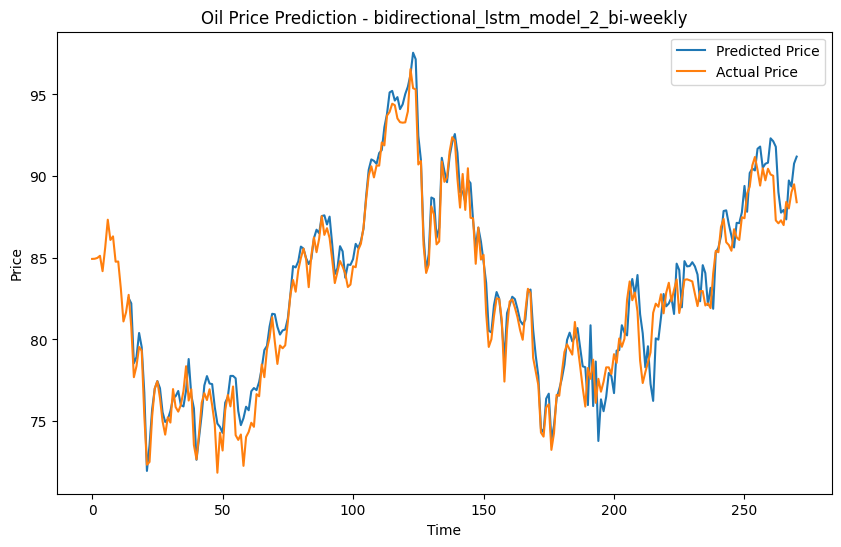



 ------- early_patience: 15  restore_best: True lr_patience:5
Epoch 1/100
175/175 [==============================] - 11s 18ms/step - loss: 0.0019 - mean_absolute_percentage_error: 742812.5000 - mean_absolute_error: 0.0343 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 14.3380 - val_mean_absolute_error: 0.0548 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0022 - mean_absolute_percentage_error: 790868.6875 - mean_absolute_error: 0.0359 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 16.7493 - val_mean_absolute_error: 0.0649 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0019 - mean_absolute_percentage_error: 676321.1250 - mean_absolute_error: 0.0335 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 16.8810 - val_mean_absolute_error: 0.0659 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_percentage_error: 82674

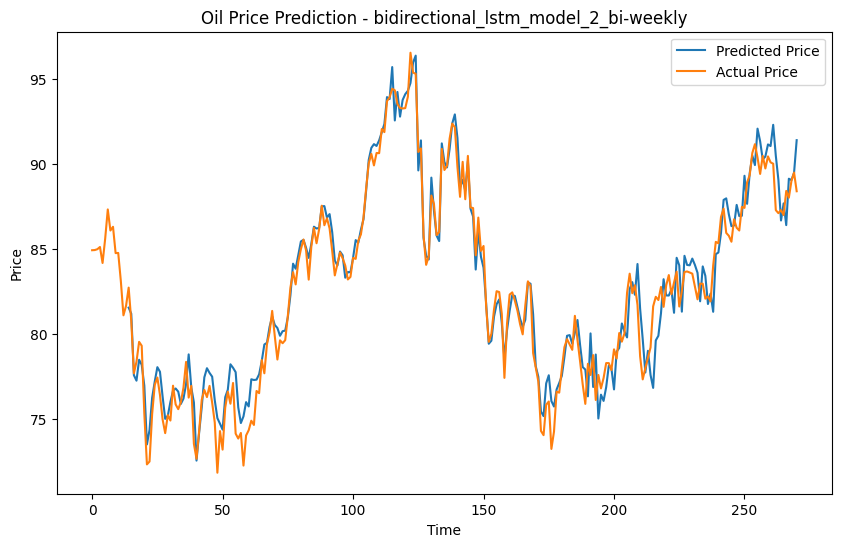



 ------- early_patience: 15  restore_best: True lr_patience:7
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0023 - mean_absolute_percentage_error: 748142.2500 - mean_absolute_error: 0.0370 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 15.0998 - val_mean_absolute_error: 0.0587 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_percentage_error: 1021222.1875 - mean_absolute_error: 0.0376 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 15.9493 - val_mean_absolute_error: 0.0629 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0016 - mean_absolute_percentage_error: 454636.6562 - mean_absolute_error: 0.0308 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 17.5526 - val_mean_absolute_error: 0.0693 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0028 - mean_absolute_percentage_error: 974268.

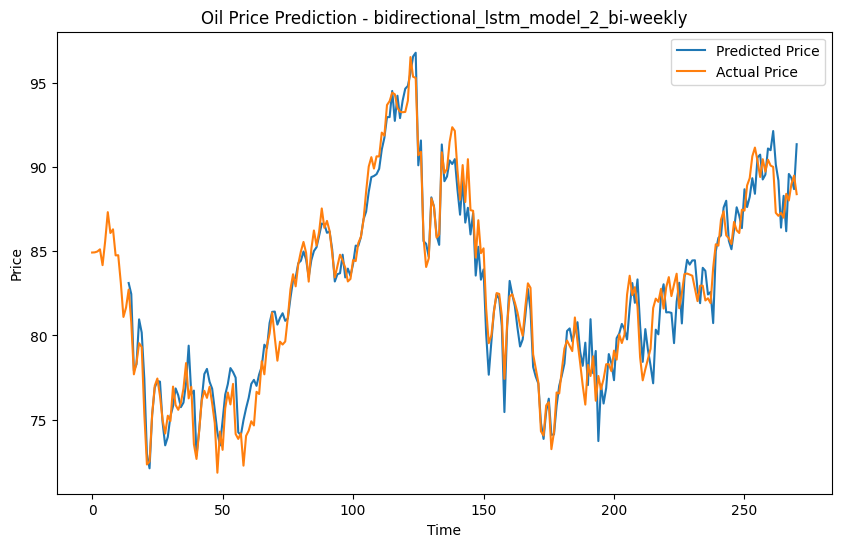



 ------- early_patience: 15  restore_best: False lr_patience:3
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0025 - mean_absolute_percentage_error: 710702.6875 - mean_absolute_error: 0.0406 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 16.0208 - val_mean_absolute_error: 0.0601 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0025 - mean_absolute_percentage_error: 276557.7500 - mean_absolute_error: 0.0396 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 16.5835 - val_mean_absolute_error: 0.0632 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0024 - mean_absolute_percentage_error: 325331.9062 - mean_absolute_error: 0.0378 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 14.3822 - val_mean_absolute_error: 0.0549 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0022 - mean_absolute_percentage_error: 983710

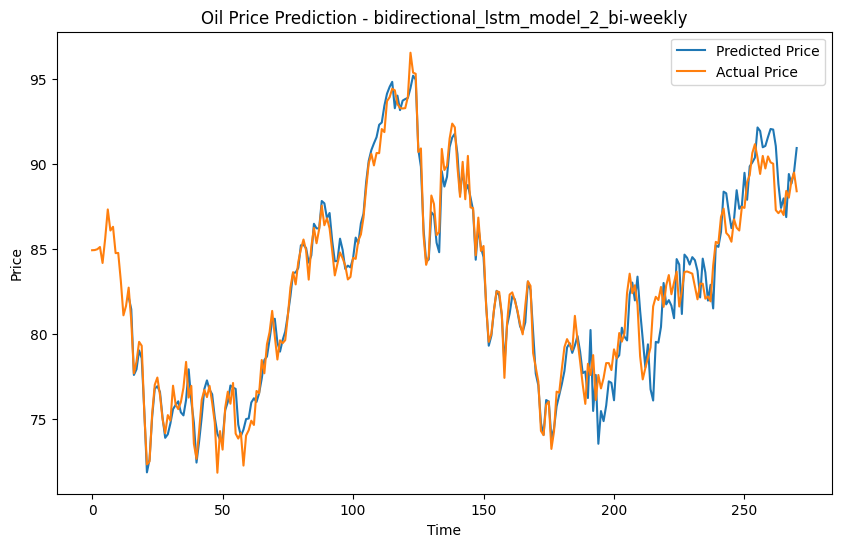



 ------- early_patience: 15  restore_best: False lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0017 - mean_absolute_percentage_error: 544025.1875 - mean_absolute_error: 0.0321 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 17.7416 - val_mean_absolute_error: 0.0684 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_percentage_error: 622452.5000 - mean_absolute_error: 0.0341 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 16.8495 - val_mean_absolute_error: 0.0651 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 582705.0000 - mean_absolute_error: 0.0361 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 18.0218 - val_mean_absolute_error: 0.0669 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0023 - mean_absolute_percentage_error: 547678.

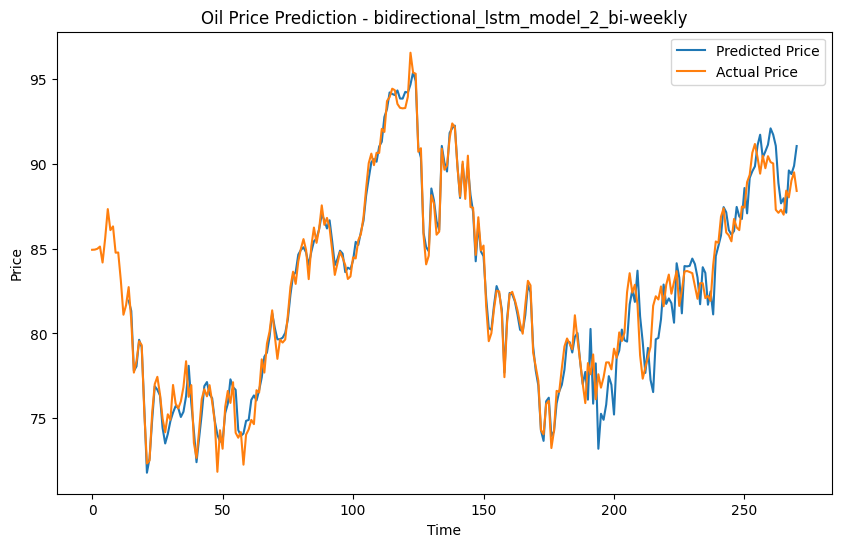



 ------- early_patience: 15  restore_best: False lr_patience:7
Epoch 1/100
175/175 [==============================] - 11s 20ms/step - loss: 0.0020 - mean_absolute_percentage_error: 746060.3125 - mean_absolute_error: 0.0348 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 16.0947 - val_mean_absolute_error: 0.0615 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0022 - mean_absolute_percentage_error: 734236.6875 - mean_absolute_error: 0.0378 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 16.3559 - val_mean_absolute_error: 0.0626 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0020 - mean_absolute_percentage_error: 825523.9375 - mean_absolute_error: 0.0353 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 14.7771 - val_mean_absolute_error: 0.0584 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0021 - mean_absolute_percentage_error: 4968

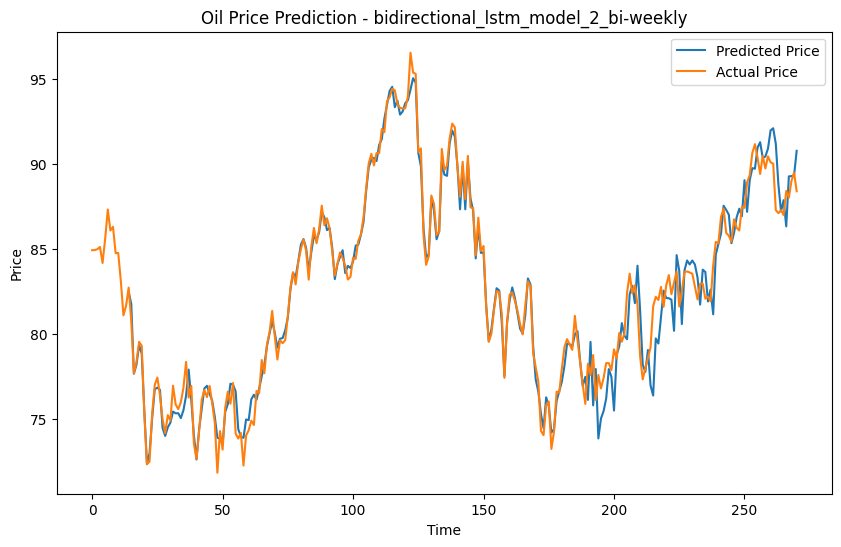



 ------- early_patience: 20  restore_best: True lr_patience:3
Epoch 1/100
175/175 [==============================] - 10s 19ms/step - loss: 0.0018 - mean_absolute_percentage_error: 853829.9375 - mean_absolute_error: 0.0323 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 16.0638 - val_mean_absolute_error: 0.0612 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0017 - mean_absolute_percentage_error: 884064.4375 - mean_absolute_error: 0.0309 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.7822 - val_mean_absolute_error: 0.0587 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0020 - mean_absolute_percentage_error: 918102.8750 - mean_absolute_error: 0.0352 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 15.1303 - val_mean_absolute_error: 0.0595 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0020 - mean_absolute_percentage_error: 863697.

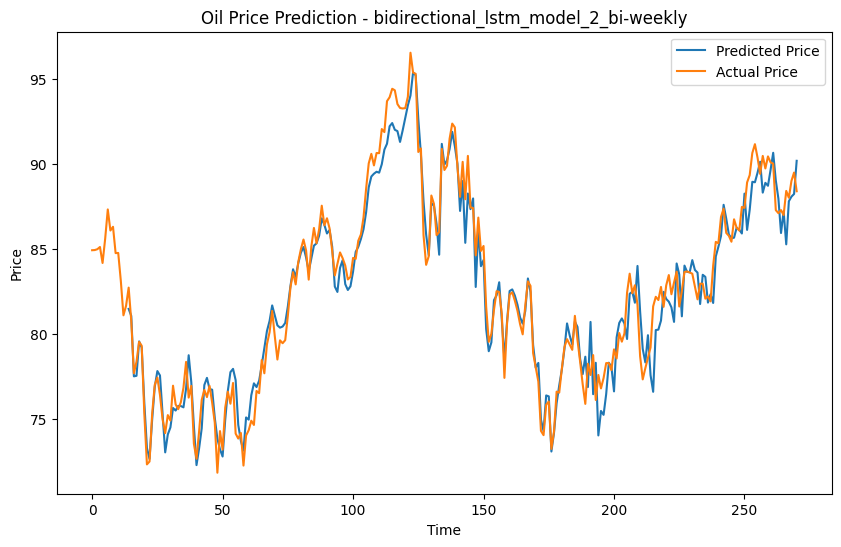



 ------- early_patience: 20  restore_best: True lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 17ms/step - loss: 0.0017 - mean_absolute_percentage_error: 544492.6875 - mean_absolute_error: 0.0329 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 14.1250 - val_mean_absolute_error: 0.0527 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0023 - mean_absolute_percentage_error: 698829.7500 - mean_absolute_error: 0.0372 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 13.1436 - val_mean_absolute_error: 0.0507 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 764688.2500 - mean_absolute_error: 0.0358 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 15.8454 - val_mean_absolute_error: 0.0617 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0019 - mean_absolute_percentage_error: 1062653.

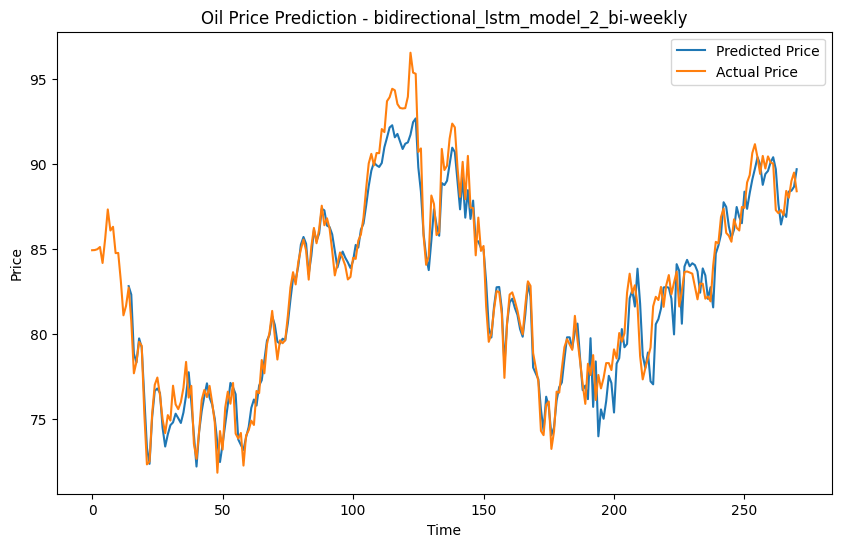



 ------- early_patience: 20  restore_best: True lr_patience:7
Epoch 1/100
175/175 [==============================] - 11s 18ms/step - loss: 0.0019 - mean_absolute_percentage_error: 538707.6875 - mean_absolute_error: 0.0335 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 17.0536 - val_mean_absolute_error: 0.0657 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 789760.8125 - mean_absolute_error: 0.0355 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 15.1460 - val_mean_absolute_error: 0.0596 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0019 - mean_absolute_percentage_error: 951570.7500 - mean_absolute_error: 0.0334 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 17.5855 - val_mean_absolute_error: 0.0662 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0019 - mean_absolute_percentage_error: 705085

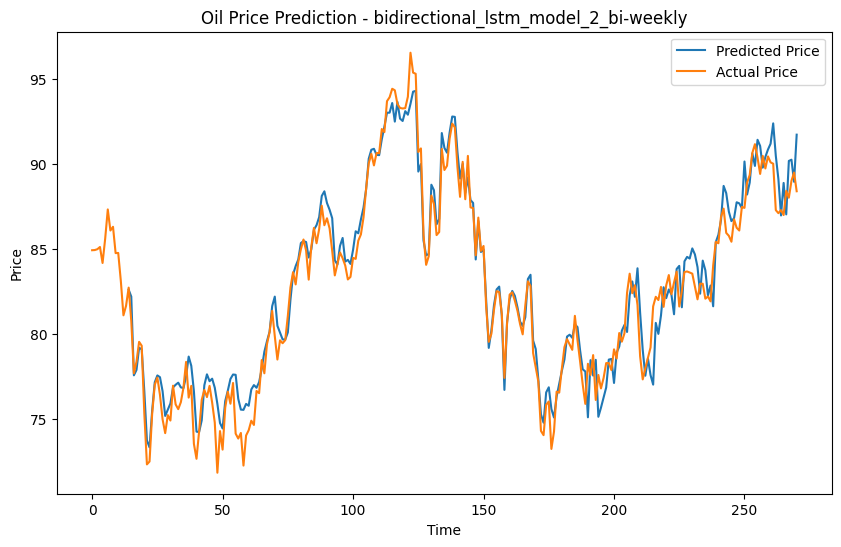



 ------- early_patience: 20  restore_best: False lr_patience:3
Epoch 1/100
175/175 [==============================] - 10s 17ms/step - loss: 0.0022 - mean_absolute_percentage_error: 604810.2500 - mean_absolute_error: 0.0363 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 14.7503 - val_mean_absolute_error: 0.0575 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 8ms/step - loss: 0.0016 - mean_absolute_percentage_error: 852596.5000 - mean_absolute_error: 0.0301 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 16.1914 - val_mean_absolute_error: 0.0629 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 664751.1250 - mean_absolute_error: 0.0307 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 16.5799 - val_mean_absolute_error: 0.0650 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 781983.

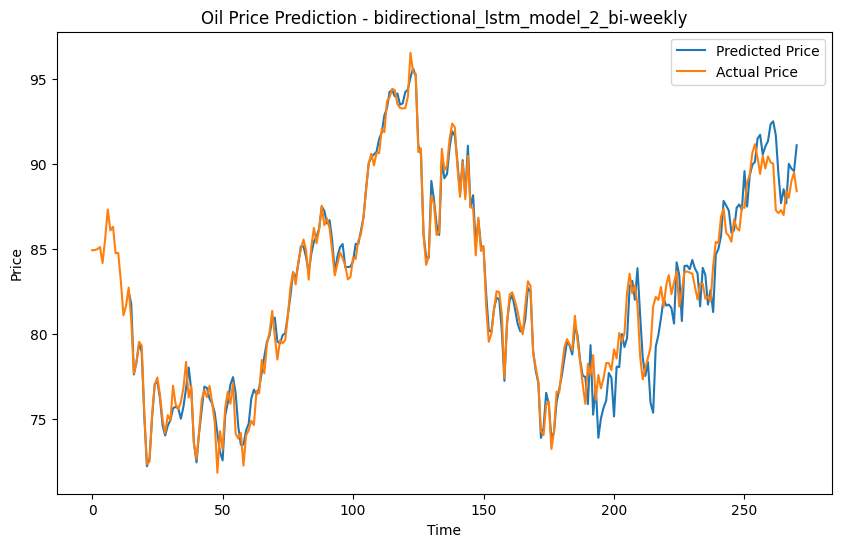



 ------- early_patience: 20  restore_best: False lr_patience:5
Epoch 1/100
175/175 [==============================] - 10s 18ms/step - loss: 0.0016 - mean_absolute_percentage_error: 696264.8750 - mean_absolute_error: 0.0312 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 15.4717 - val_mean_absolute_error: 0.0603 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0018 - mean_absolute_percentage_error: 751818.4375 - mean_absolute_error: 0.0334 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 15.8442 - val_mean_absolute_error: 0.0621 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0022 - mean_absolute_percentage_error: 821605.5000 - mean_absolute_error: 0.0369 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 15.0467 - val_mean_absolute_error: 0.0588 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 736548

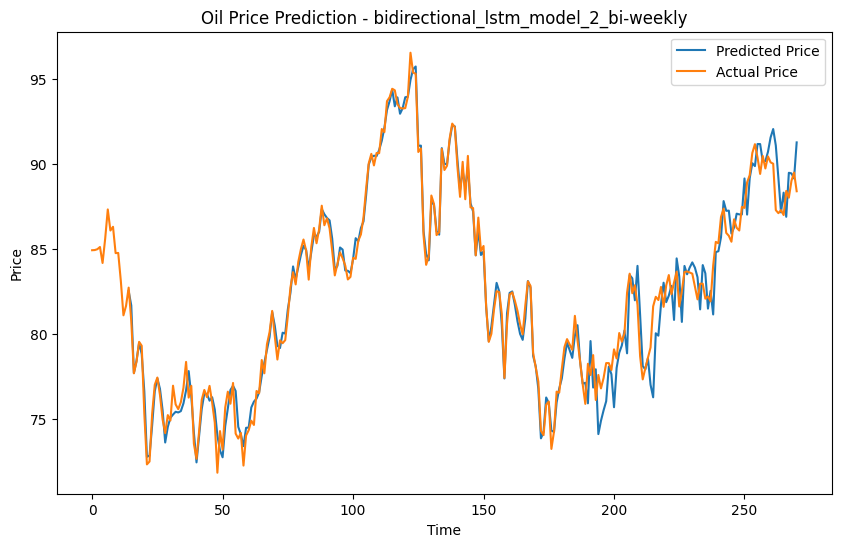



 ------- early_patience: 20  restore_best: False lr_patience:7
Epoch 1/100
175/175 [==============================] - 21s 18ms/step - loss: 0.0014 - mean_absolute_percentage_error: 695632.6250 - mean_absolute_error: 0.0291 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 14.9273 - val_mean_absolute_error: 0.0565 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_percentage_error: 749958.2500 - mean_absolute_error: 0.0329 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 16.6311 - val_mean_absolute_error: 0.0643 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0014 - mean_absolute_percentage_error: 754962.3750 - mean_absolute_error: 0.0290 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 15.9406 - val_mean_absolute_error: 0.0639 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 2s 10ms/step - loss: 0.0015 - mean_absolute_percentage_error: 70290

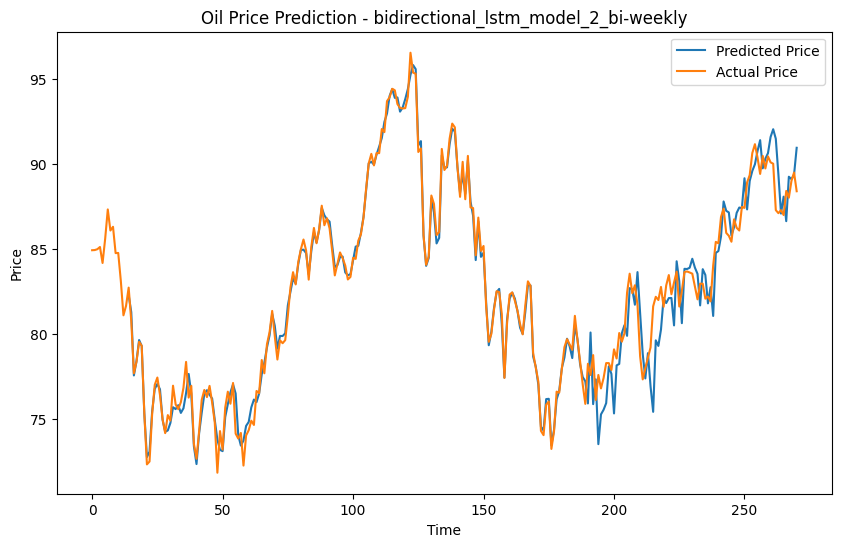

In [90]:
results=compile_and_fit_with_grid_search(model, window)

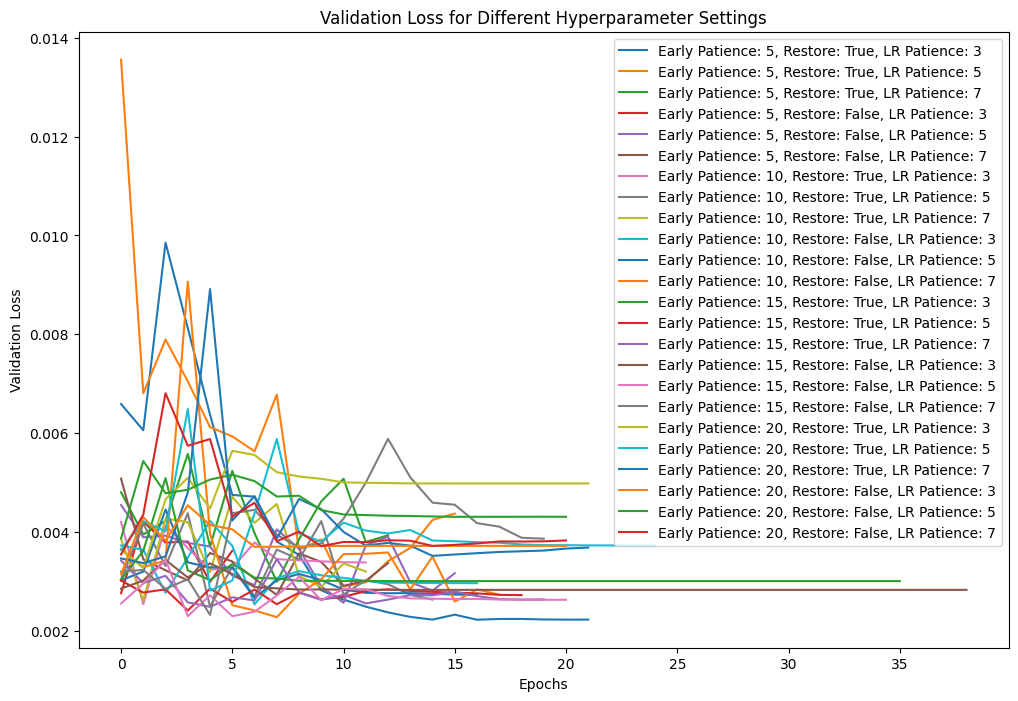

Best Hyperparameters: {'early_patience': 5, 'restore_best_weights': True, 'reduce_lr_patience': 3, 'val_loss': [0.006588222924619913, 0.0060560512356460094, 0.009854188188910484, 0.008124304004013538, 0.006371085066348314, 0.004747122526168823, 0.004712235182523727, 0.003803631290793419, 0.0035306846257299185, 0.0028166519477963448, 0.002628375543281436, 0.002485499018803239, 0.0023688976652920246, 0.0022778024431318045, 0.002222853945568204, 0.00232320767827332, 0.002220693975687027, 0.002236002590507269, 0.0022369236685335636, 0.002225621836259961, 0.0022231333423405886, 0.0022236595395952463], 'final_val_loss': 0.0022236595395952463}


In [86]:

# Find the best result based on final validation loss
best_result = min(results, key=lambda x: x['final_val_loss'])

# Plot the results for visualization
plt.figure(figsize=(12, 8))
for result in results:
    plt.plot(result['val_loss'], label=f"Early Patience: {result['early_patience']}, Restore: {result['restore_best_weights']}, LR Patience: {result['reduce_lr_patience']}")

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss for Different Hyperparameter Settings')
plt.show()

print(f"Best Hyperparameters: {best_result}")

257/257 [==============================] - 2s 2ms/step


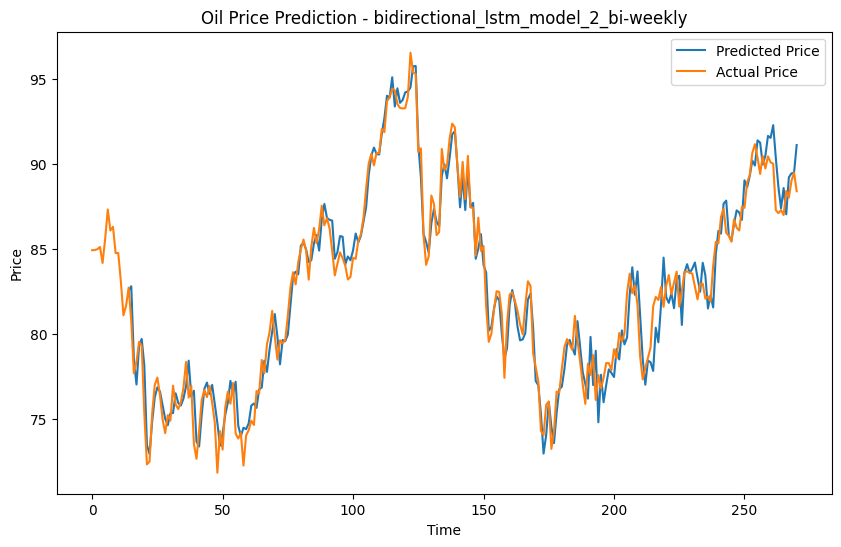

In [87]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
# Y_all_data = oil_data['Price'].values
# Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

all_predict = model.predict(window.all_data)
try:

    X_all_data = scaler.inverse_transform(all_predict)

    plt.figure(figsize=(10, 6))
    plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
    plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
    plt.title(f'Oil Price Prediction - {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    # plt.savefig(f'outputs/oil/LSTM {model_name} Oil Price Prediction.png')
    plt.show()
except:
    print("Error", model_name, all_predict.shape)